In [1]:
import requests
import time
from bs4 import BeautifulSoup, Comment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
colors = ["dusty lavender", "salmon", "ochre", "dusty rose", "coral", "mud", "barbie pink",\
            "dirty pink", "purpleish", "kermit green", "drab", "pale rose", "wisteria",\
            "butter", "bland"]
palette = sns.xkcd_palette(colors)
sns.set_palette(palette)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
#declare season months, rivalries, stadium capacities, and popularity data
months = ['october', 'november','december', 'january', 'february', 'march', 'april', 'may', 'june']

rivalries = {frozenset({'Cleveland Cavaliers','Golden State Warriors'}),
            frozenset({'Boston Celtics','Los Angeles Lakers'}),
            frozenset({'Detroit Pistons','Los Angeles Lakers'}),
            frozenset({'Philadelphia 76ers','Boston Celtics'}),
            frozenset({'Boston Celtics','New York Knicks'}),
            frozenset({'New York Knicks','Brooklyn Nets'}),
            frozenset({'Chicago Bulls','Detroit Pistons'}),
            frozenset({'Chicago Bulls','Cleveland Cavaliers'}),
            frozenset({'Miami Heat','Orlando Magic'}),
            frozenset({'Chicago Bulls','Miami Heat'}),
            frozenset({'Chicago Bulls','New York Knicks'}),
            frozenset({'Boston Celtics','Detroit Pistons'}),
            frozenset({'Miami Heat','New York Knicks'}),
            frozenset({'Indiana Pacers','New York Knicks'}),
            frozenset({'Los Angeles Clippers','Los Angeles Lakers'}),
            frozenset({'Dallas Mavericks','Houston Rockets'}),
            frozenset({'Houston Rockets','San Antonio Spurs'}),
            frozenset({'Houston Rockets', 'Utah Jazz'}),
            frozenset({'San Antonio Spurs','Los Angeles Lakers'}),
            frozenset({'Phoenix Suns','San Antonio Spurs'})}

site = 'https://en.wikipedia.org/wiki/List_of_National_Basketball_Association_arenas'
capacities=pd.read_html(site, header=0)[0]
capacities = capacities[['Team(s)', "Capacity"]]
capacities.columns = ['Home', "Capacity"]
capacities

pop_df = pd.DataFrame()
for i in np.arange(0,6):
    pop_tbl = pd.read_csv('nba_gtrend_{}.csv'.format(i),header =1)
    df = pd.DataFrame(pop_tbl.mean())
    df['Home'] = df.index
    df = df.reset_index(drop=True)
    pop_df = pop_df.append(df,ignore_index = True)
    pop_df['Home'] =  pop_df['Home'].str.replace(r'\:.*', '')
    
pop_df    

0                    Home
0   29.903846              Miami Heat
1   24.307692        Dallas Mavericks
2   10.673077           Orlando Magic
3   29.615385       San Antonio Spurs
4   14.000000          Indiana Pacers
5    1.903846           Brooklyn Nets
6   16.480769   Golden State Warriors
7   12.807692         Milwaukee Bucks
8    3.000000        Sacramento Kings
9    4.519231         Detroit Pistons
10   8.711538         New York Knicks
11   8.884615  Portland Trail Blazers
12   3.750000          Denver Nuggets
13   2.903846     Cleveland Cavaliers
14   8.442308         Toronto Raptors
15   2.211538    New Orleans Pelicans
16   5.326923    Los Angeles Clippers
17  31.192308      Los Angeles Lakers
18   2.269231           Atlanta Hawks
19   3.000000            Phoenix Suns
20   2.538462  Minnesota Timberwolves
21  15.692308          Boston Celtics
22  13.134615         Houston Rockets
23   5.903846           Chicago Bulls
24   4.423077               Utah Jazz
25  12.480769      Philadelphia 76ers

In [22]:
all_data_df = pd.DataFrame()
#iterate over years 2015-2019 (nets franchise change) and all active season months
for year in np.arange(2015,2020):
    year_data_df = pd.DataFrame()
    for month in months:
        site = requests.get('https://www.basketball-reference.com/leagues/NBA_{}_games-{}.html'.format(year,month))
        soup = BeautifulSoup(site.content, 'html.parser')
        sched = soup.find(id = 'schedule')
        try:
            tr = sched.find_all('tr')
        except:
            continue
        data = [[th.getText() for th in tr[i].findAll('th')]
                    for i in range(len(tr))]
        col_labels = data[0]
        dates = np.array(data[1:])
        dates_df = pd.DataFrame(data = dates, columns = ['Date'])
        data = [[td.getText() for td in tr[i].findAll('td')]
                    for i in range(len(tr))]
        data_df = pd.DataFrame(data = data[1:], columns = col_labels[1:])
        both_df = pd.concat([dates_df,data_df], axis = 1)
        year_data_df = year_data_df.append(both_df,ignore_index = True)
        
    #combine date and time
    year_data_df['Time'] = year_data_df["Date"].map(str) + " " + year_data_df["Start (ET)"].map(str)   
    
    #determine row at which playoffs begin, drop that row, and add column to show if row is playoff game
    playoffs = year_data_df.loc[year_data_df['Date'] == "Playoffs"].index.values[0]
    year_data_df = year_data_df.drop(year_data_df.index[playoffs]).reset_index(drop= True)
    year_data_df['Playoffs?'] = np.where(year_data_df.index.values < playoffs, 0, 1)
    
    #Drop rows where note exists
    year_data_df = year_data_df[year_data_df.Notes == ''].reset_index(drop = True)
    
    #Drop unnecessary columns
    year_data_df = year_data_df.drop(['Date', 'Start (ET)','\xa0','\xa0','Notes'], axis=1)
    
    #rename and rearrange columns
    year_data_df.columns = ['Visitor', 'V PTS','Home','H PTS', 'Attendance', 'Time', 'Playoffs?']
    cols = ['Attendance', 'Time','Visitor', 'V PTS','Home','H PTS', 'Playoffs?']
    year_data_df = year_data_df.loc[:, cols]
    
    #apply types to each columns
    year_data_df['Attendance'] = year_data_df.loc[:,'Attendance'].str.replace(',', '').astype(int)
    year_data_df['Time'] = pd.to_datetime(year_data_df['Time'], infer_datetime_format = True)
    year_data_df[['V PTS', "H PTS"]] = year_data_df.loc[:,['V PTS', "H PTS"]].astype(int)
    
    #Drop rows where home is warriors, bucks, pistons, or kings since new stadiums
    year_data_df = year_data_df[year_data_df.Home != 'Golden State Warriors'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Milwaukee Bucks'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Detroit Pistons'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Sacramento Kings'].reset_index(drop = True) 
    
    #Drop rows where home is thunder, raptors, heat, cleveland, spurs, rockets, 76ers, bulls, clippers, jazz, knicks, celtics, lakers, blazers since incorrect data
    year_data_df = year_data_df[year_data_df.Home != 'Oklahoma City Thunder'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Toronto Raptors'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Miami Heat'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Cleveland Cavaliers'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'San Antonio Spurs'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Houston Rockets'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Philadelphia 76ers'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Chicago Bulls'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Los Angeles Clippers'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Utah Jazz'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'New York Knicks'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Boston Celtics'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Los Angeles Lakers'].reset_index(drop = True)
    year_data_df = year_data_df[year_data_df.Home != 'Portland Trail Blazers'].reset_index(drop = True)
    
    
    #Drop rows where attendance exceed capacity
    year_data_df = pd.merge(year_data_df, capacities, on='Home')
    year_data_df = year_data_df[year_data_df.Attendance <= year_data_df.Capacity]
    year_data_df = year_data_df.drop(['Capacity'], axis=1)
    
    #Add additional columns of data
    
    #Popularity of teams
    year_data_df = pd.merge(year_data_df, pop_df, on='Home')
    year_data_df = year_data_df.rename({0: 'Popularity'}, axis=1)
    
    #whether home won
    year_data_df['Home Win?'] = np.where(year_data_df.iloc[:,3].values < year_data_df.iloc[:,5].values, 1, 0)
    
    #day of the week game was on 
    year_data_df['Day of Week'] = year_data_df['Time'].dt.day_name()
    
    #if game is rivalry 
    year_data_df['Match-up'] = list(map(frozenset, zip(year_data_df['Visitor'], year_data_df['Home'])))
    year_data_df['Rivalry?'] = np.where(year_data_df['Match-up'].isin(rivalries), 1, 0)
    year_data_df = year_data_df.drop(['Match-up'], axis=1)
    
    #append to total df
    all_data_df = all_data_df.append(year_data_df,ignore_index = True)
    
all_data_df

Attendance                Time                 Visitor  V PTS  \
0          14547 2014-11-01 19:00:00        Dallas Mavericks    109   
1          14840 2014-11-04 20:00:00       Charlotte Hornets     91   
2          14775 2014-11-14 20:00:00  Minnesota Timberwolves     91   
3          13903 2014-12-02 20:00:00   Oklahoma City Thunder    104   
4          13789 2014-12-09 20:00:00         New York Knicks     93   
...          ...                 ...                     ...    ...   
1433       16640 2019-03-23 19:30:00      Philadelphia 76ers    127   
1434       16182 2019-03-29 19:30:00  Portland Trail Blazers    118   
1435       16660 2019-03-31 12:30:00         Milwaukee Bucks    135   
1436       16638 2019-04-03 19:30:00      Philadelphia 76ers    122   
1437       17143 2019-04-10 20:00:00          Indiana Pacers    135   

                      Home  H PTS  Playoffs?  Popularity  Home Win?  \
0     New Orleans Pelicans    104          0    2.211538          0   
1     New Orleans Pelicans    100          0    2.211538          1   
2     New Orleans Pelicans    139          0    2.211538          1   
3     New Orleans Pelicans    112          0    2.211538          1   
4     New Orleans Pelicans    104          0    2.211538          1   
...                    ...    ...        ...         ...        ...   
1433         Atlanta Hawks    129          0    2.269231          1   
1434         Atlanta Hawks     98          0    2.269231          0   
1435         Atlanta Hawks    136          0    2.269231          1   
1436         Atlanta Hawks    130          0    2.269231          1   
1437         Atlanta Hawks    134          0    2.269231          0   

     Day of Week  Rivalry?  
0       Saturday         0  
1        Tuesday         0  
2         Friday         0  
3        Tuesday         0  
4        Tuesday         0  
...          ...       ...  
1433    Saturday         0  
1434      Friday         0  
1435      Sunday         0  
1436   Wednesday         0  
1437   Wednesday         0  

[1438 rows x 11 columns]

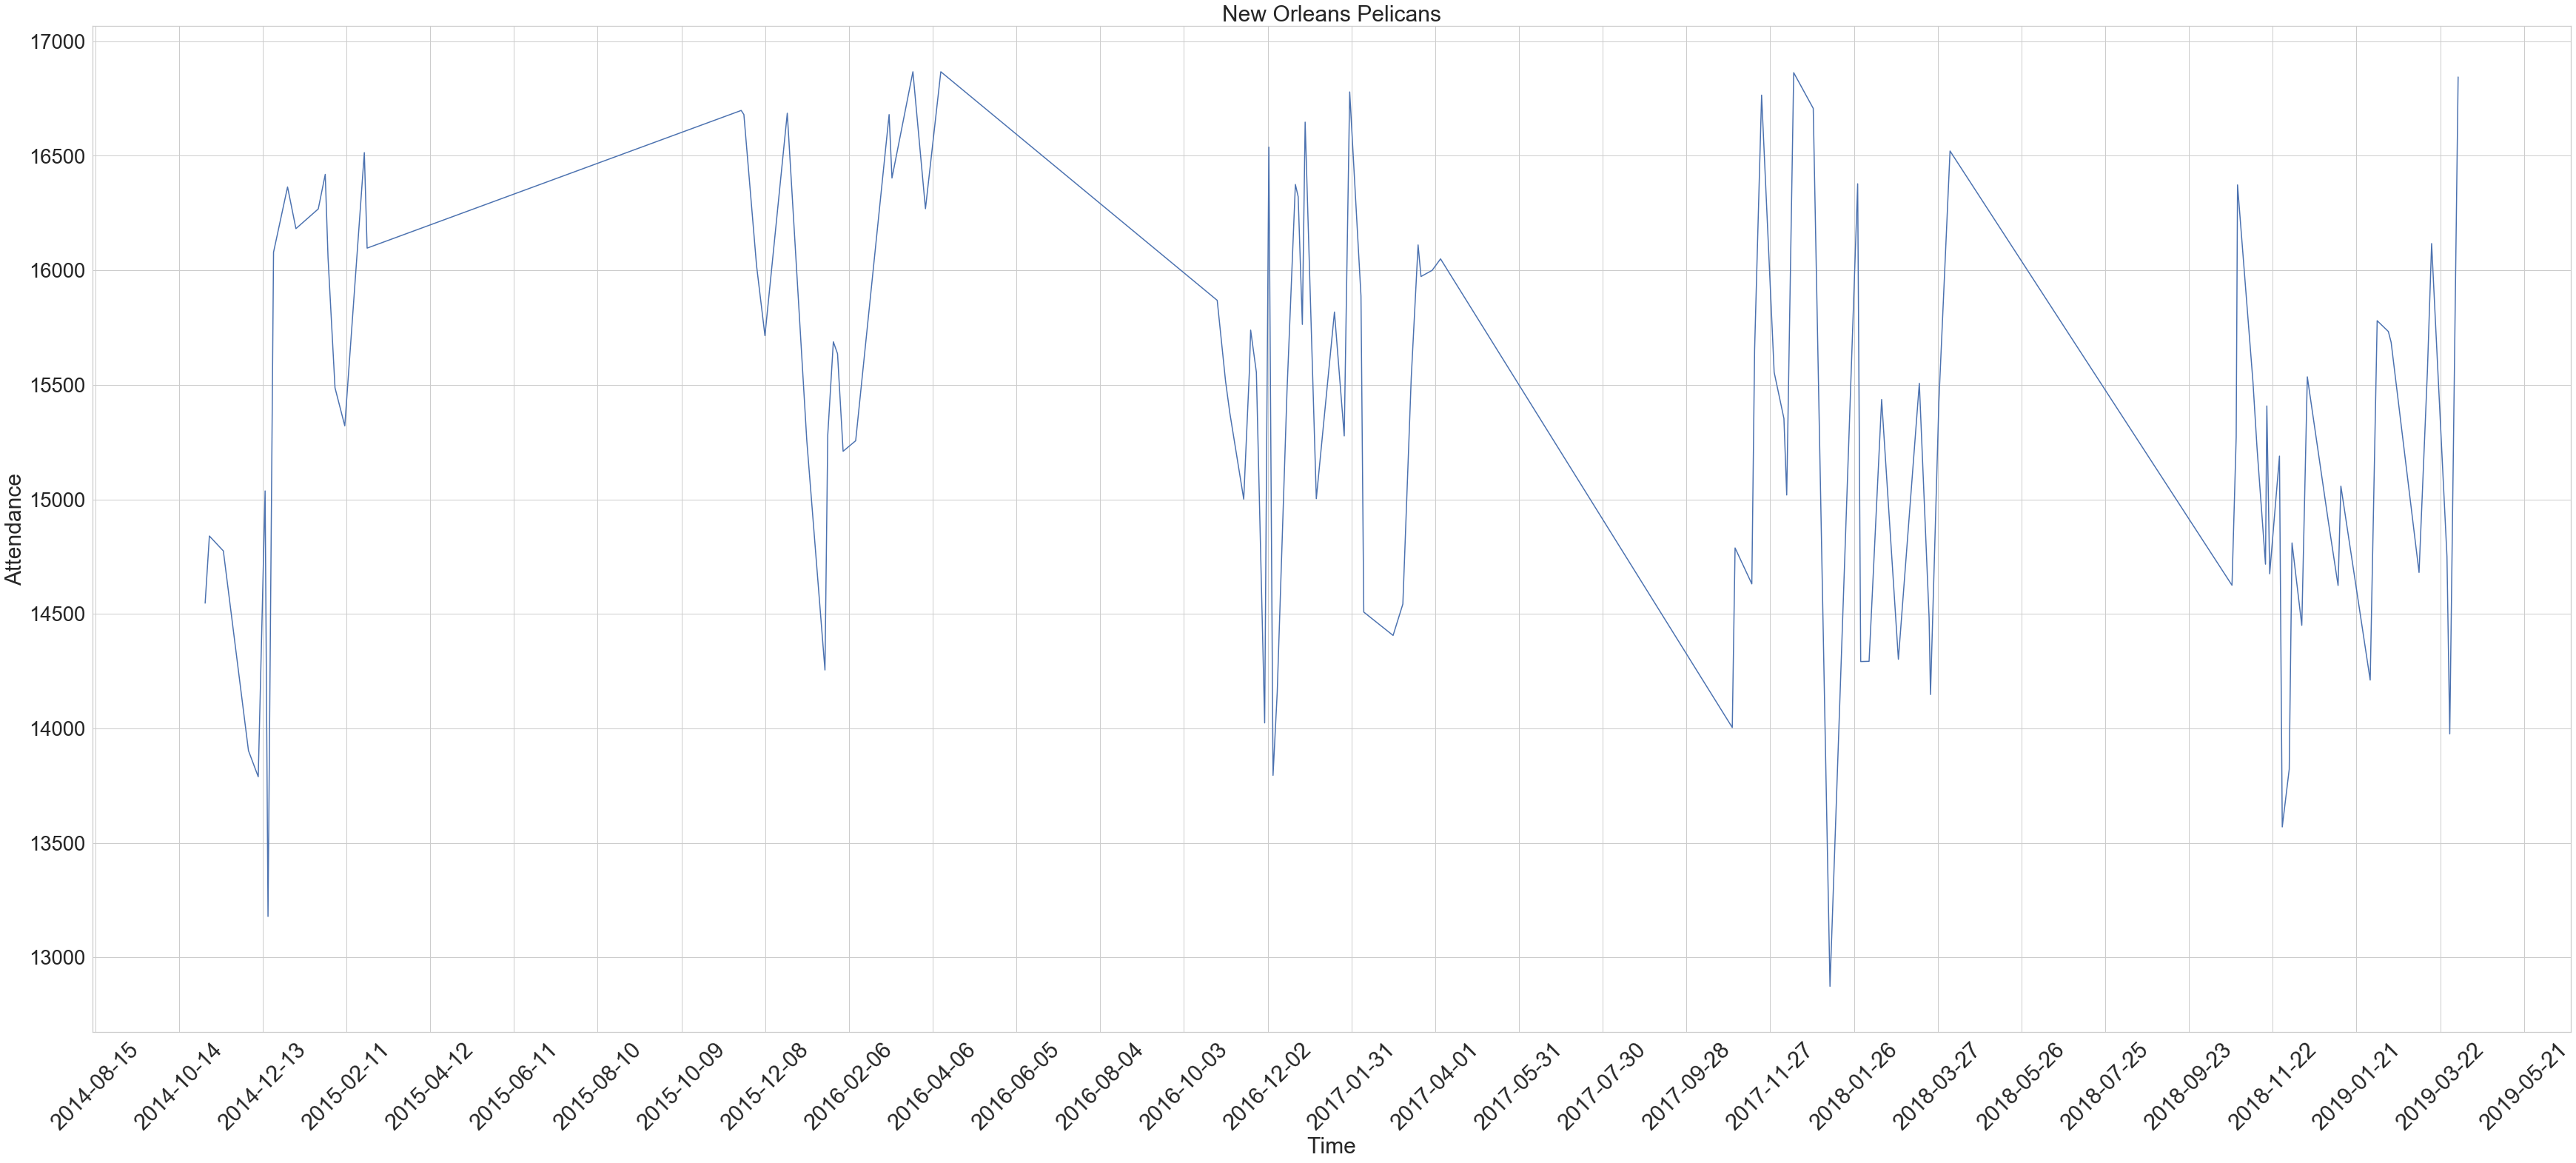

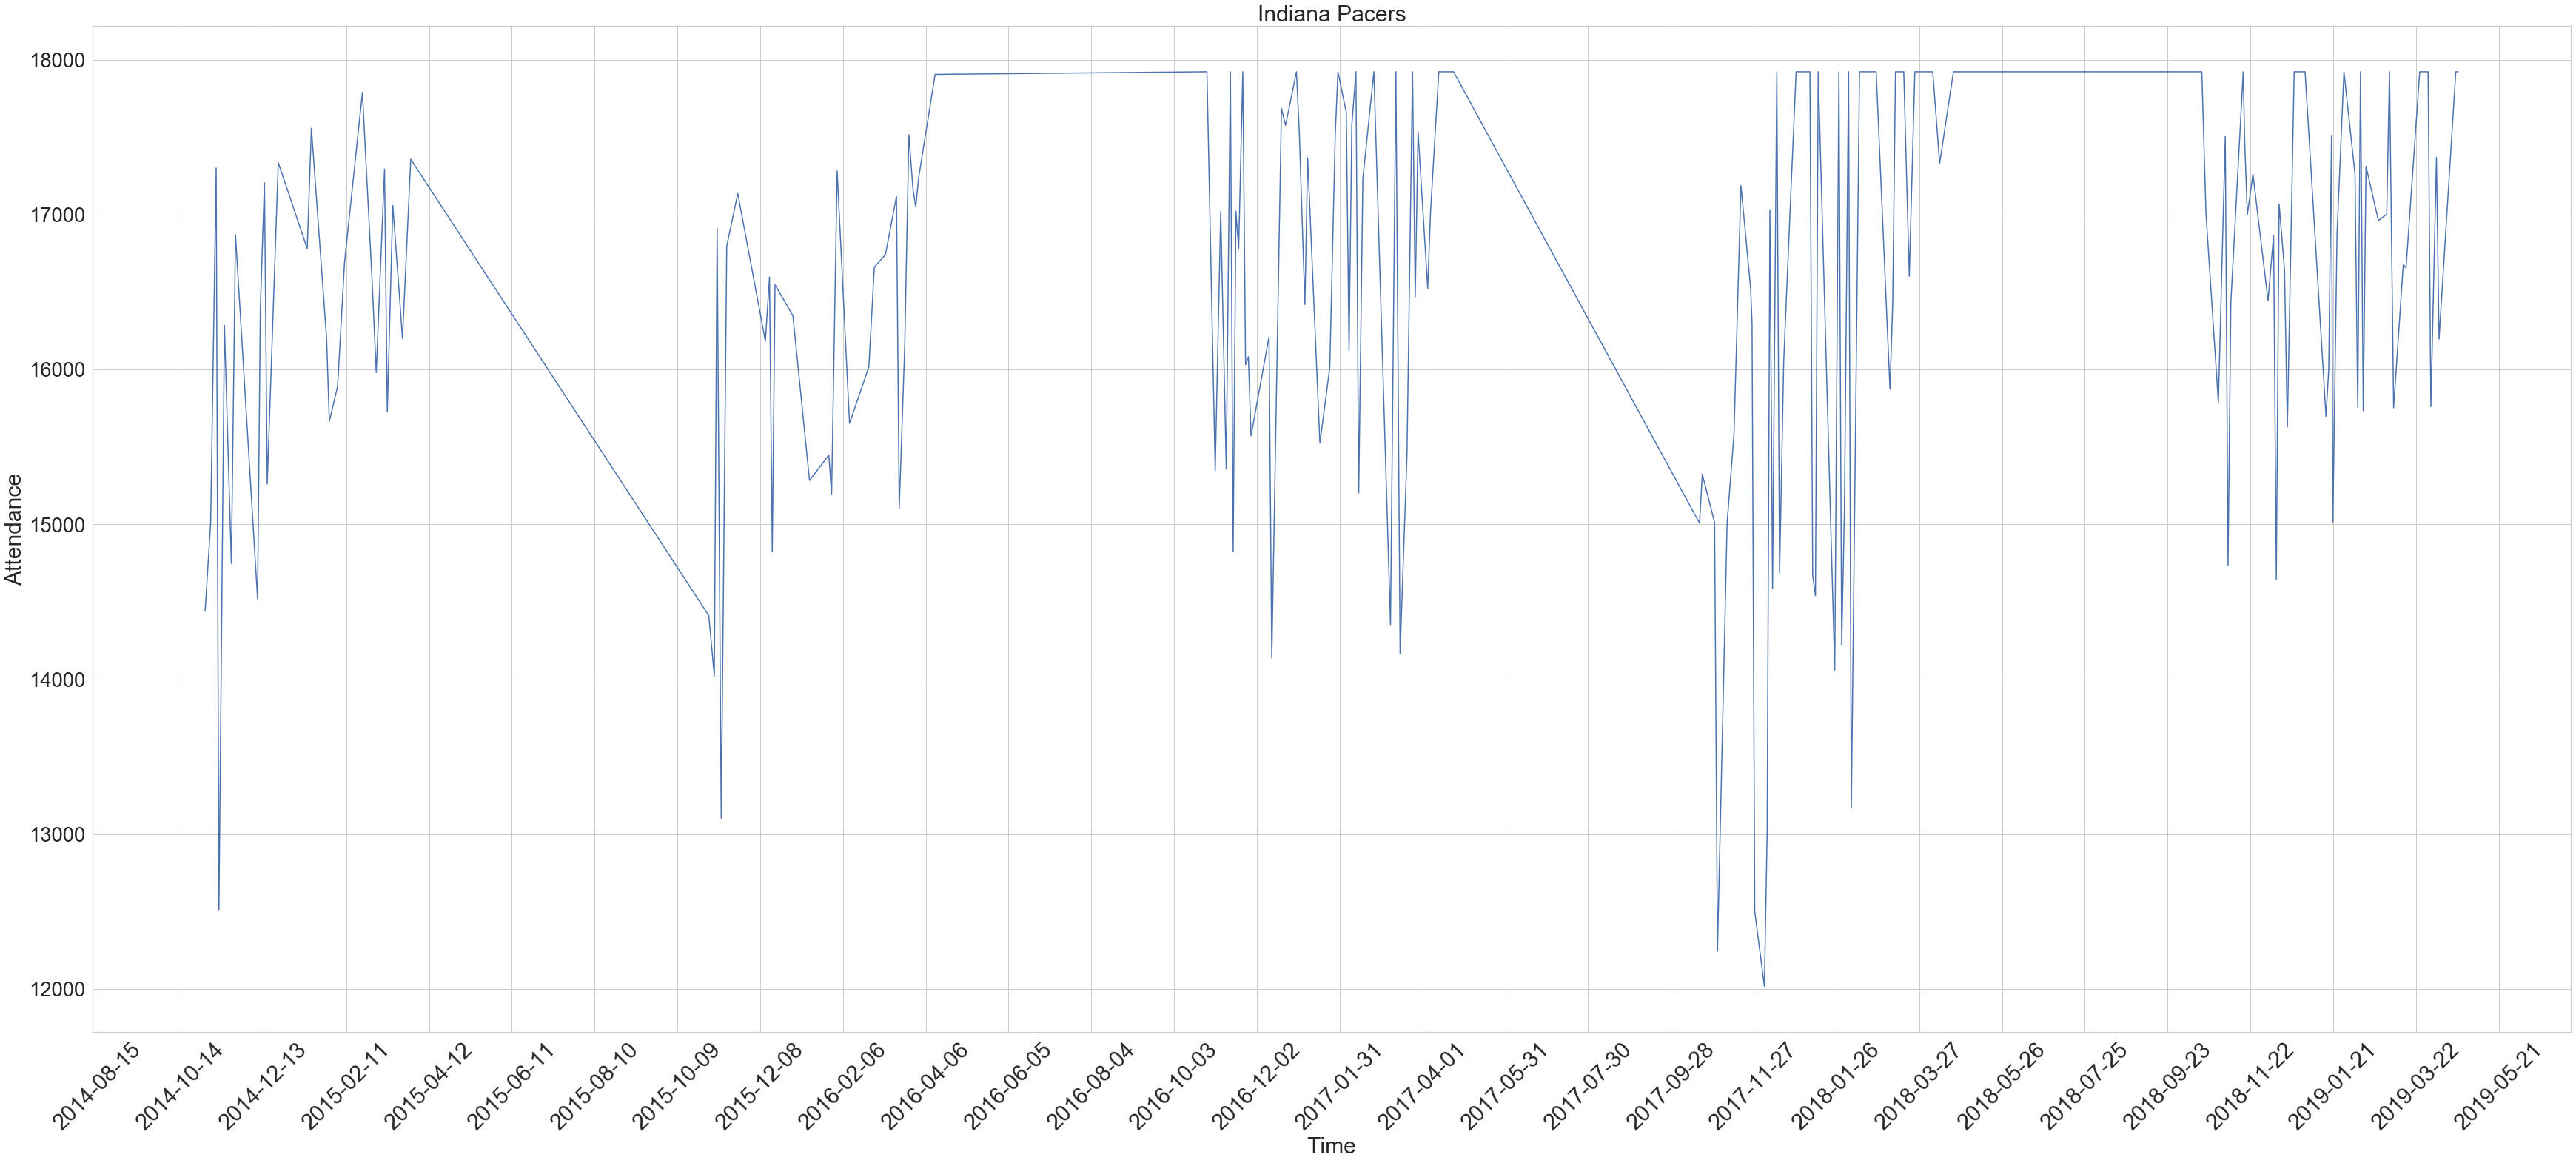

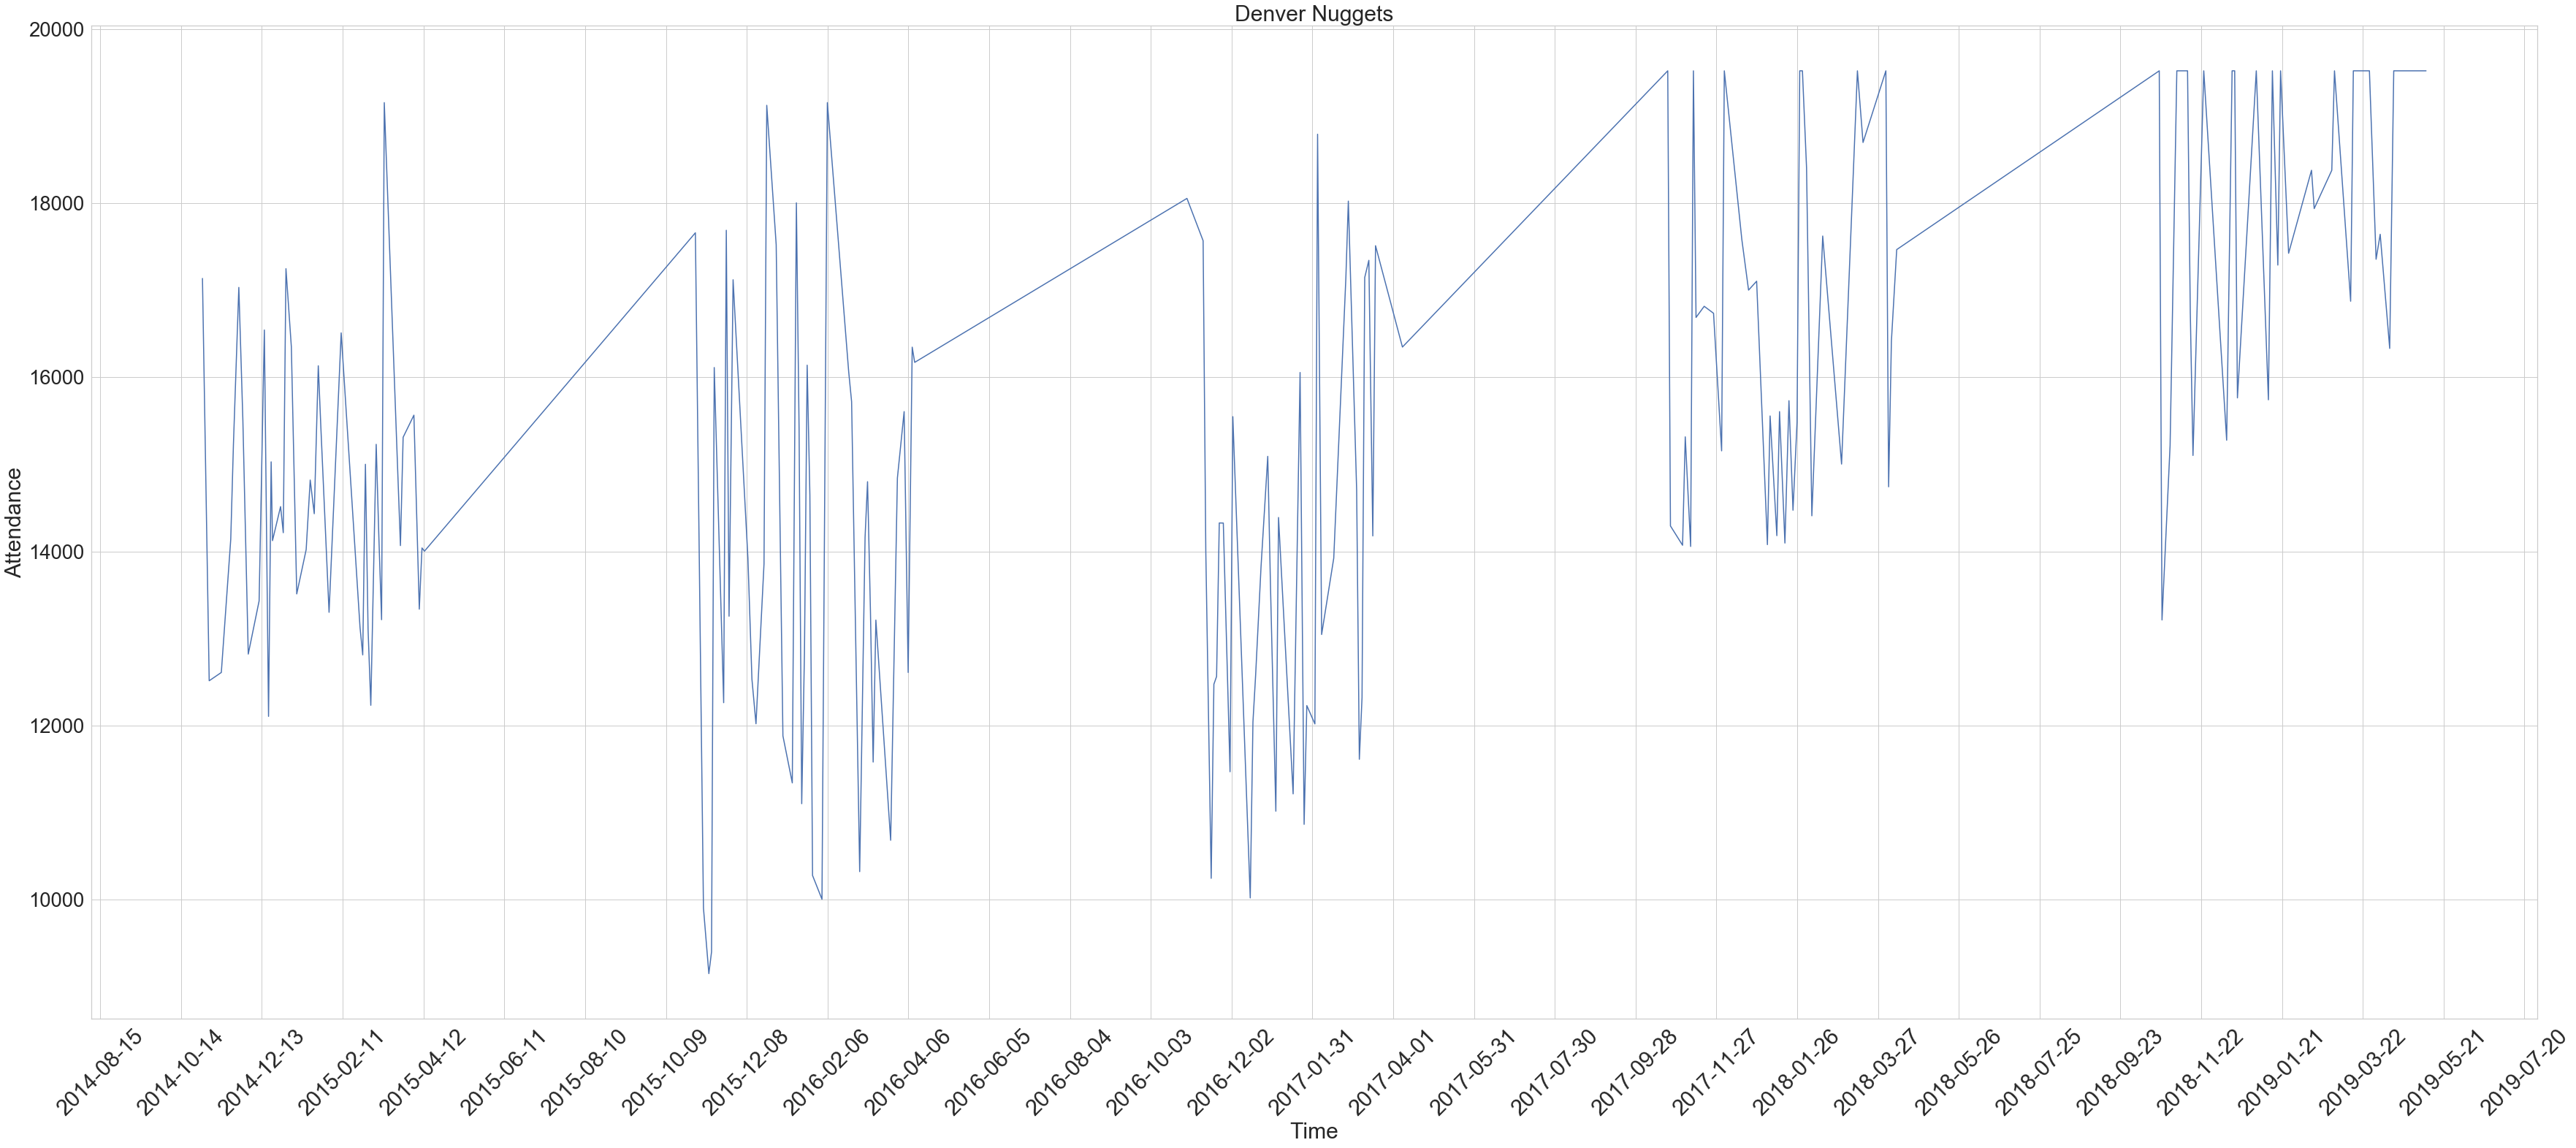

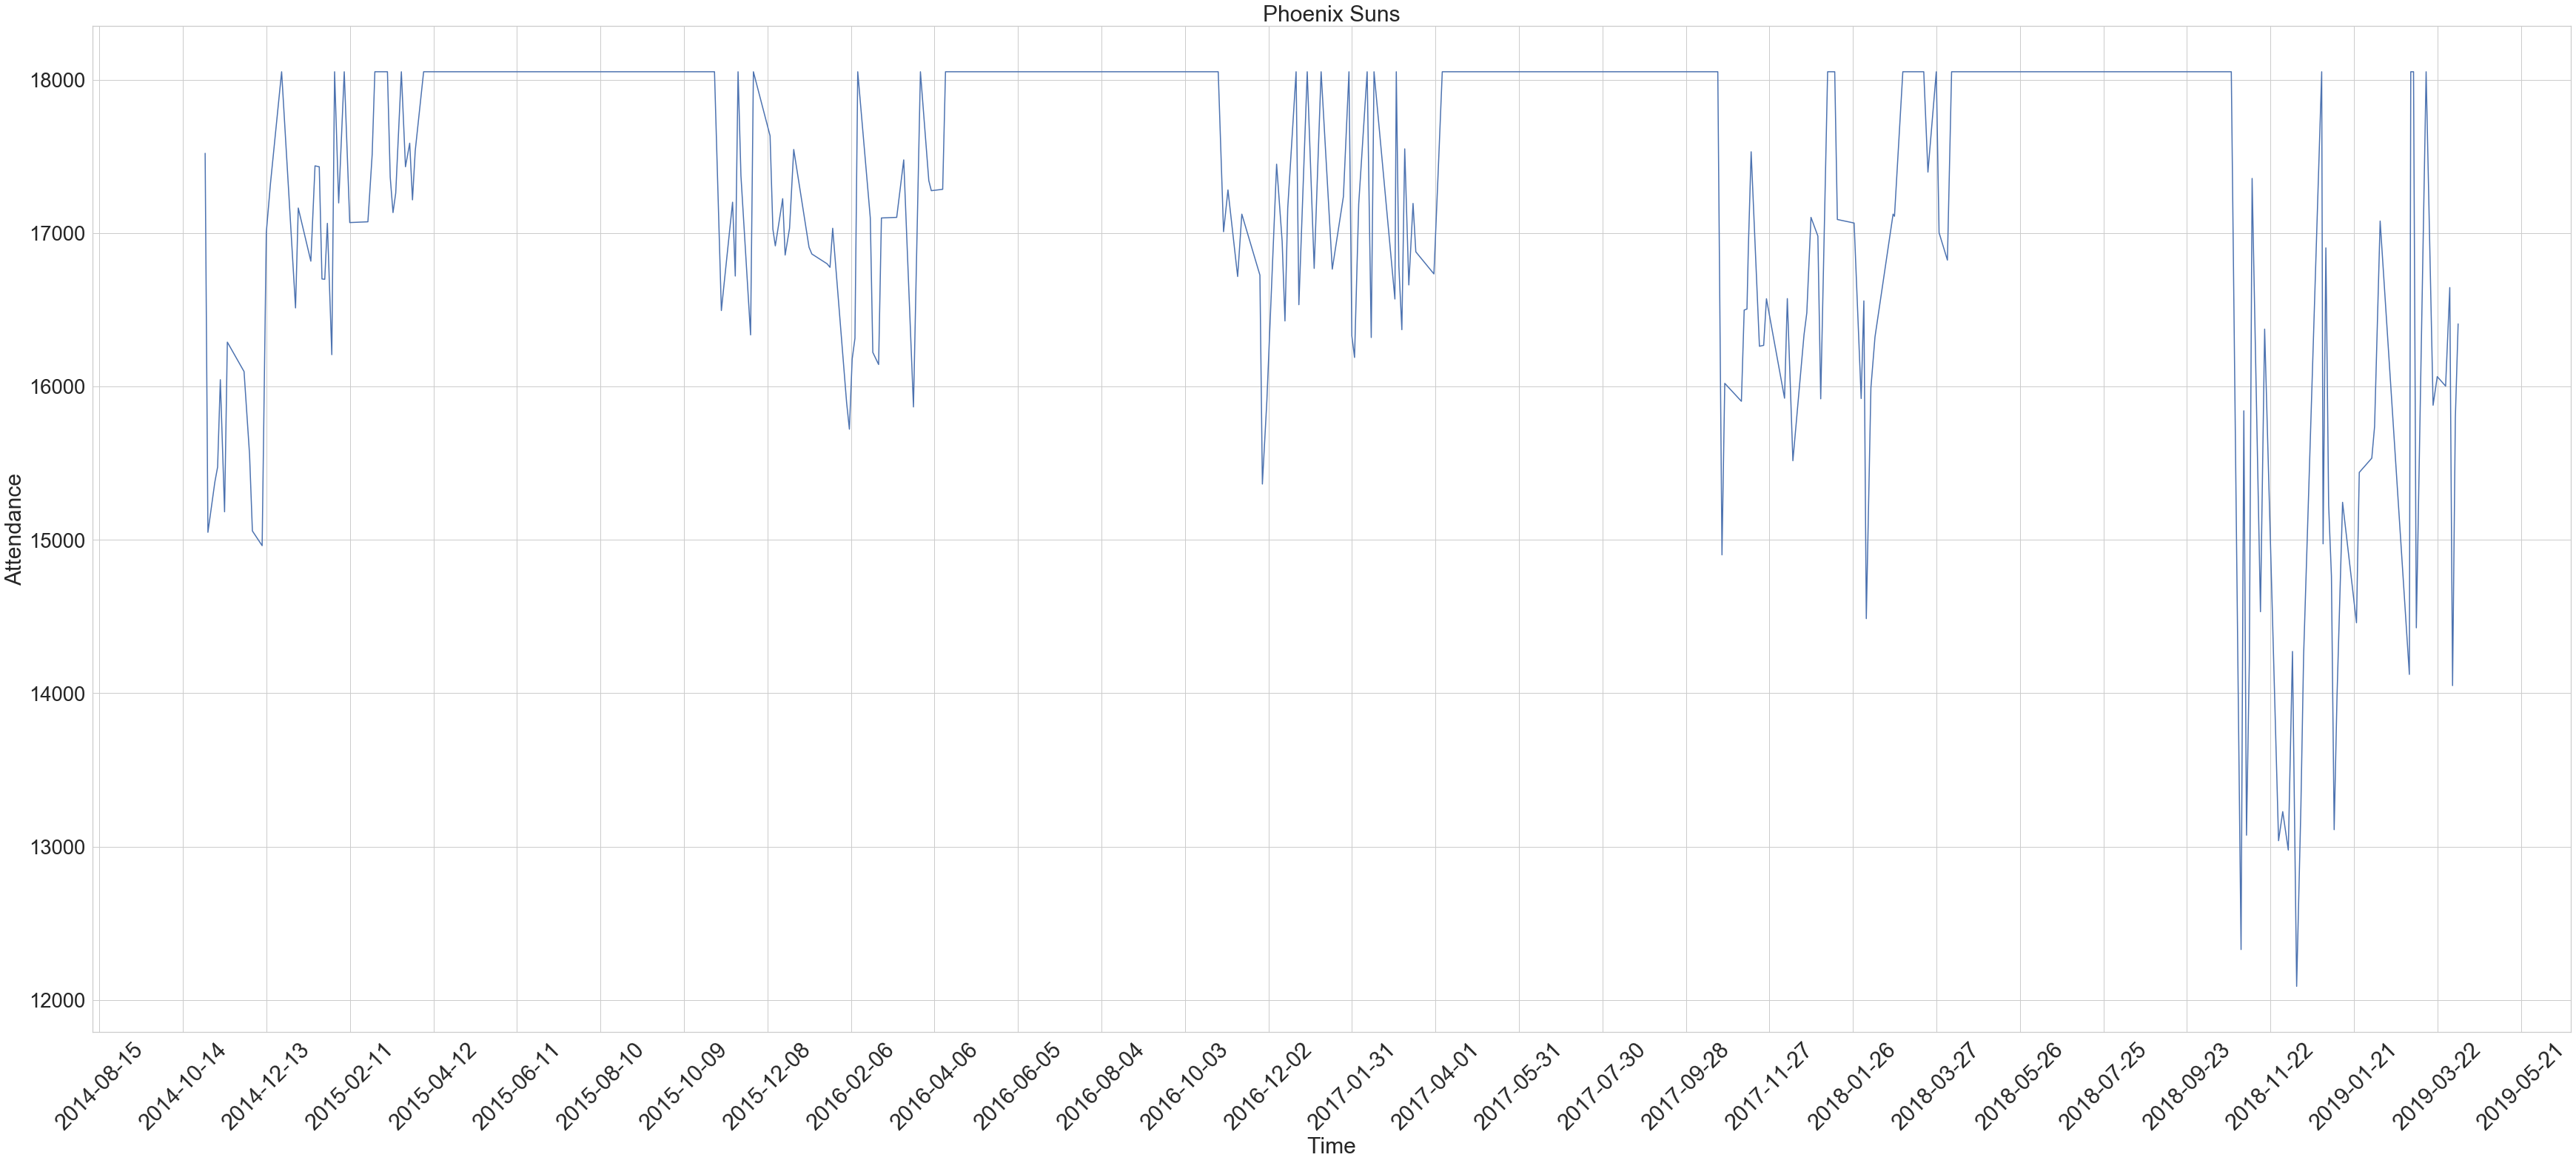

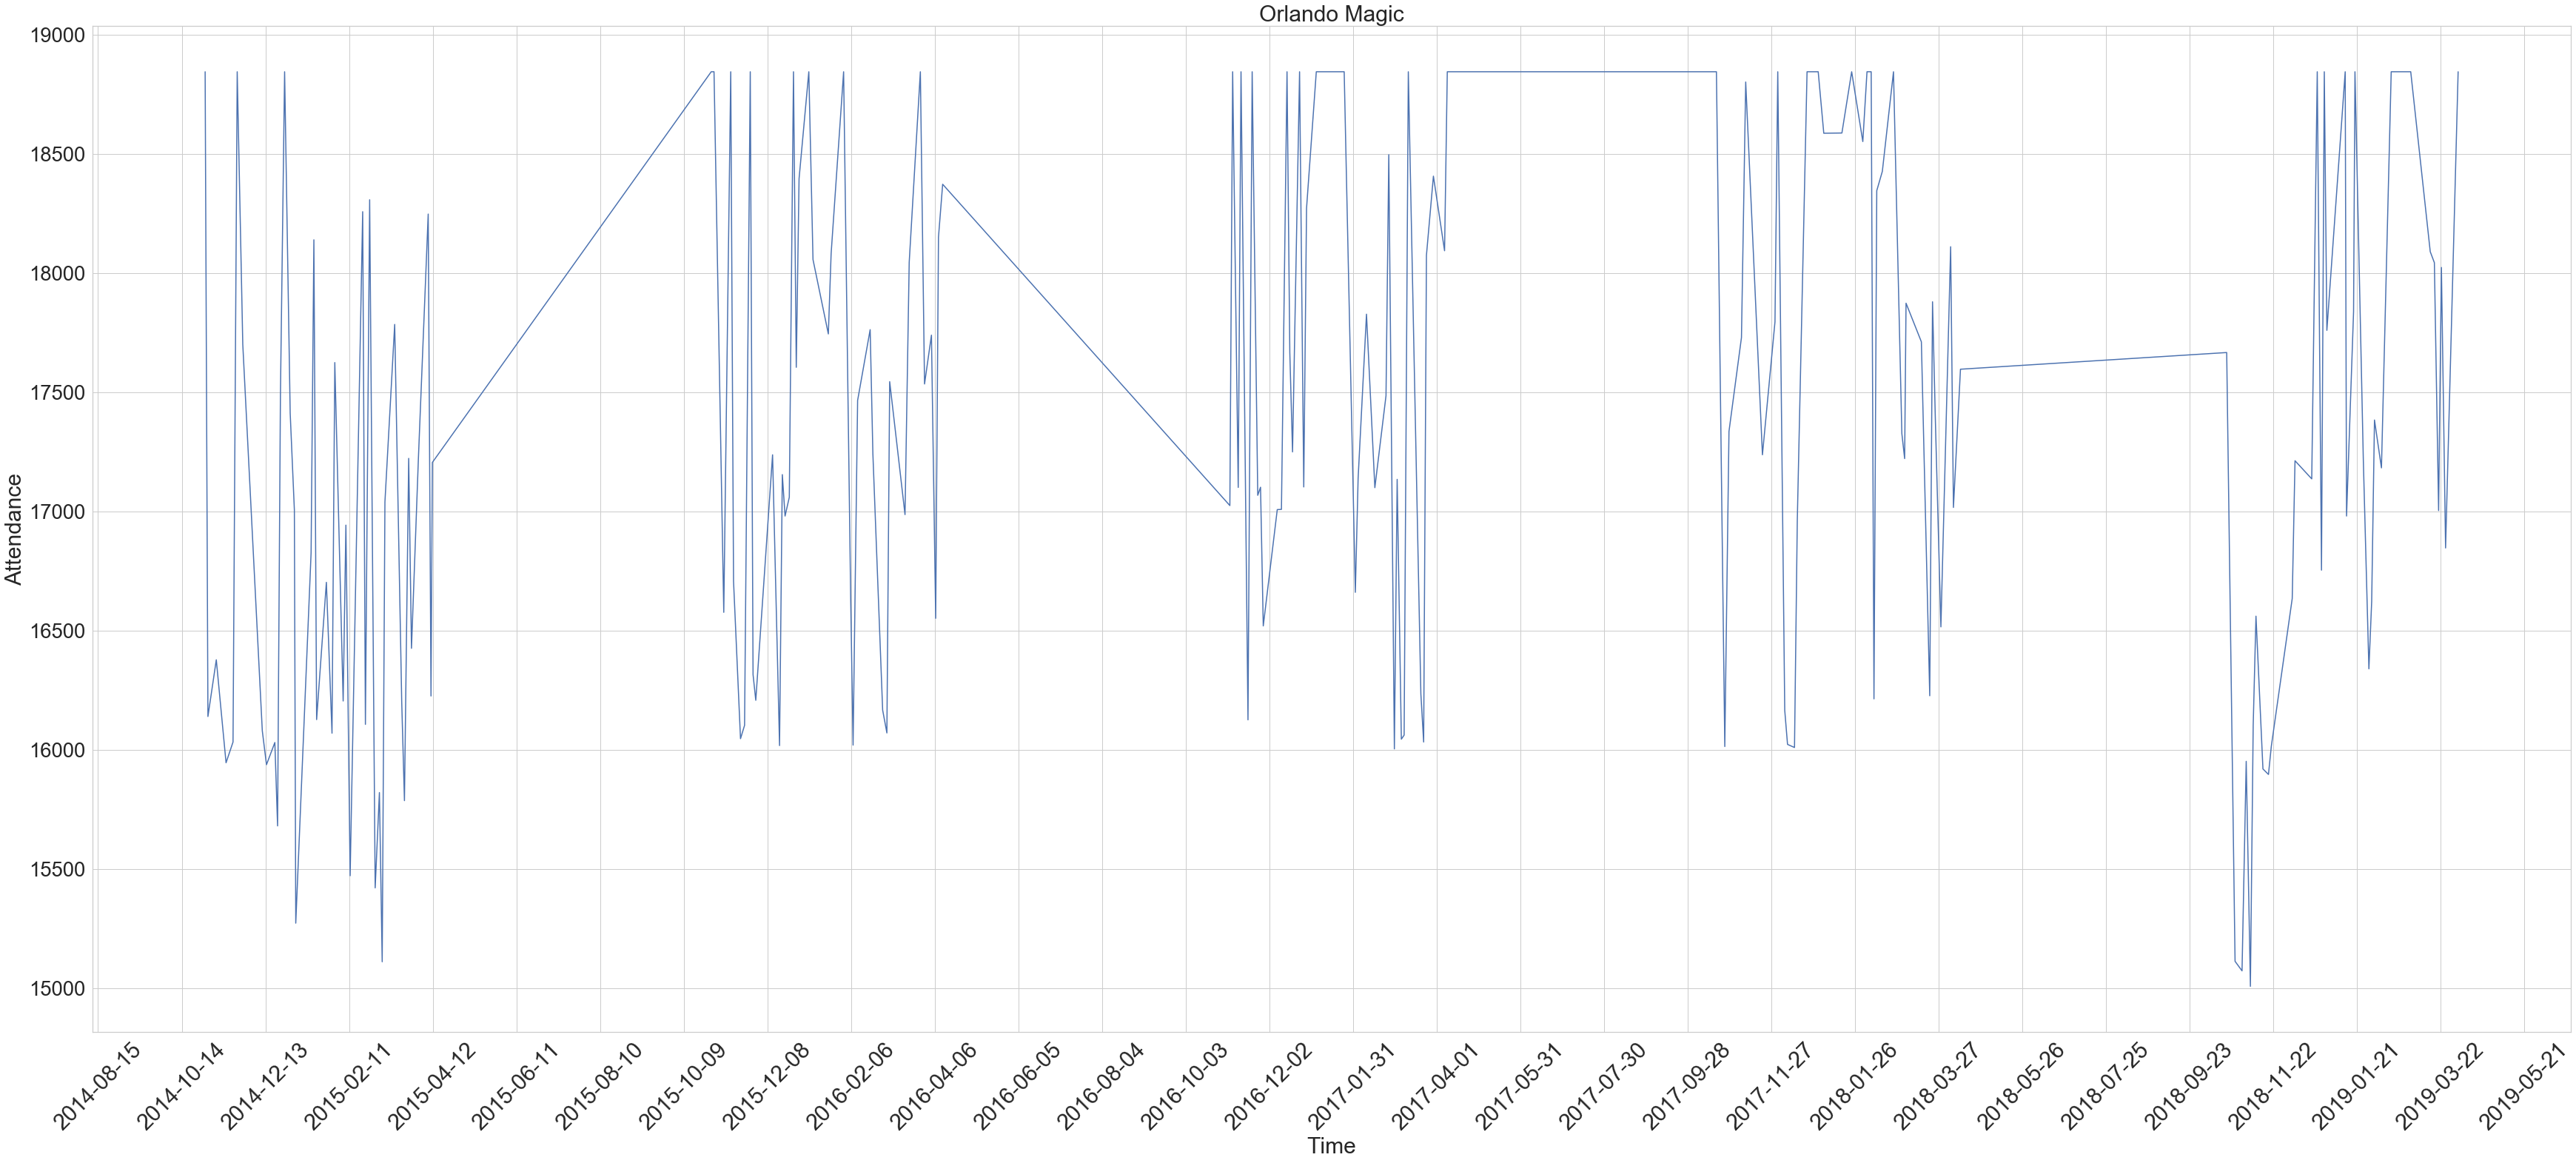

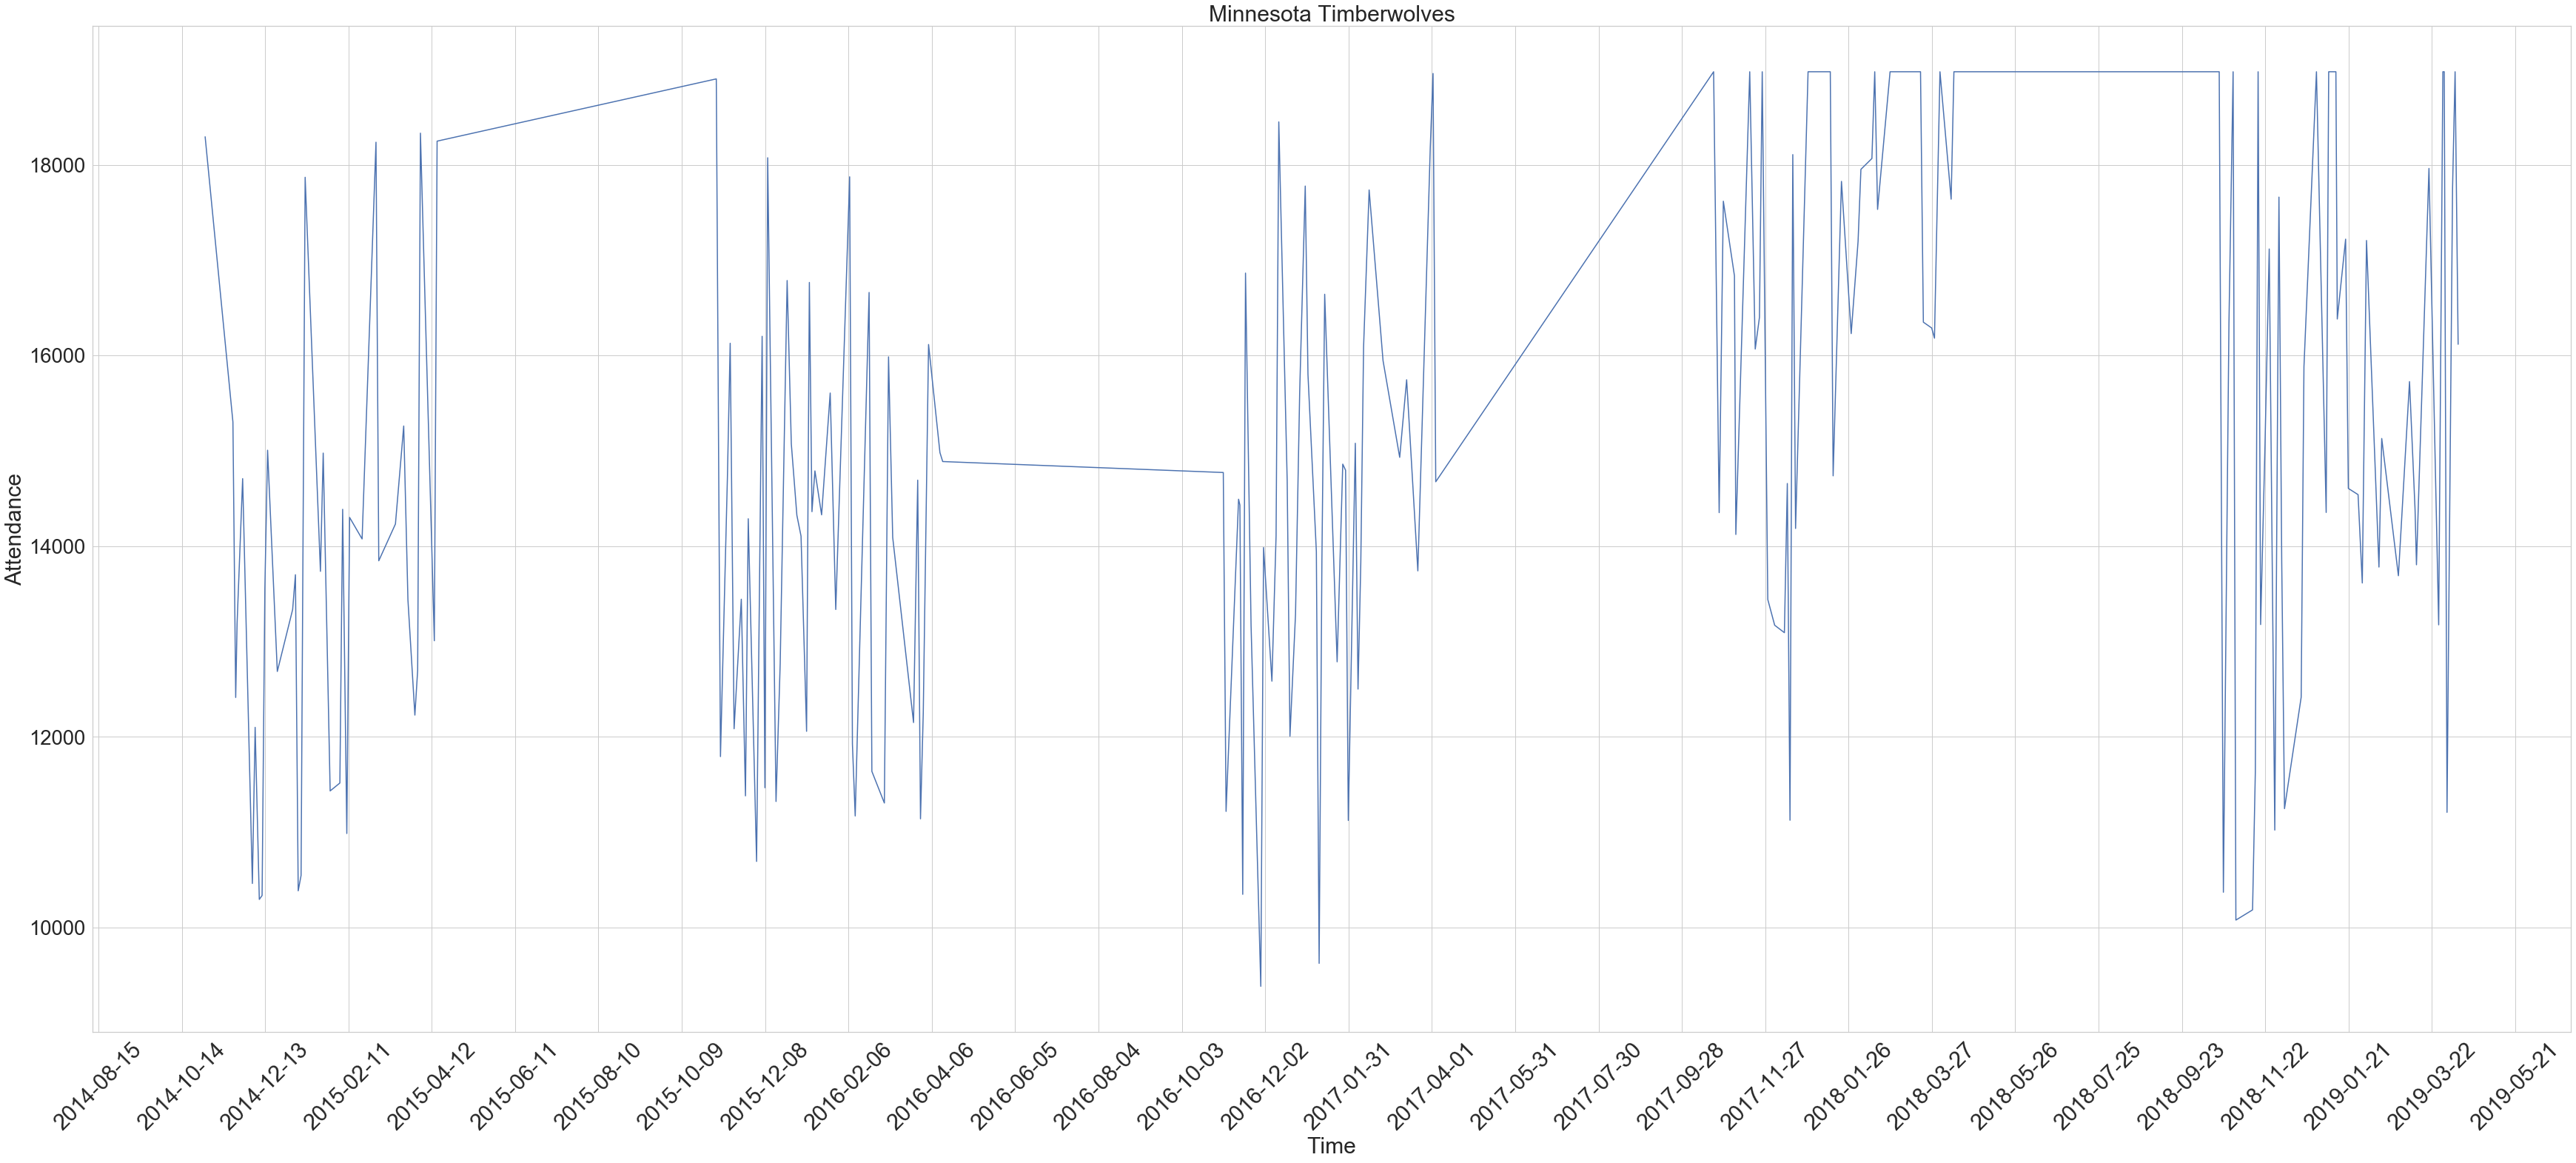

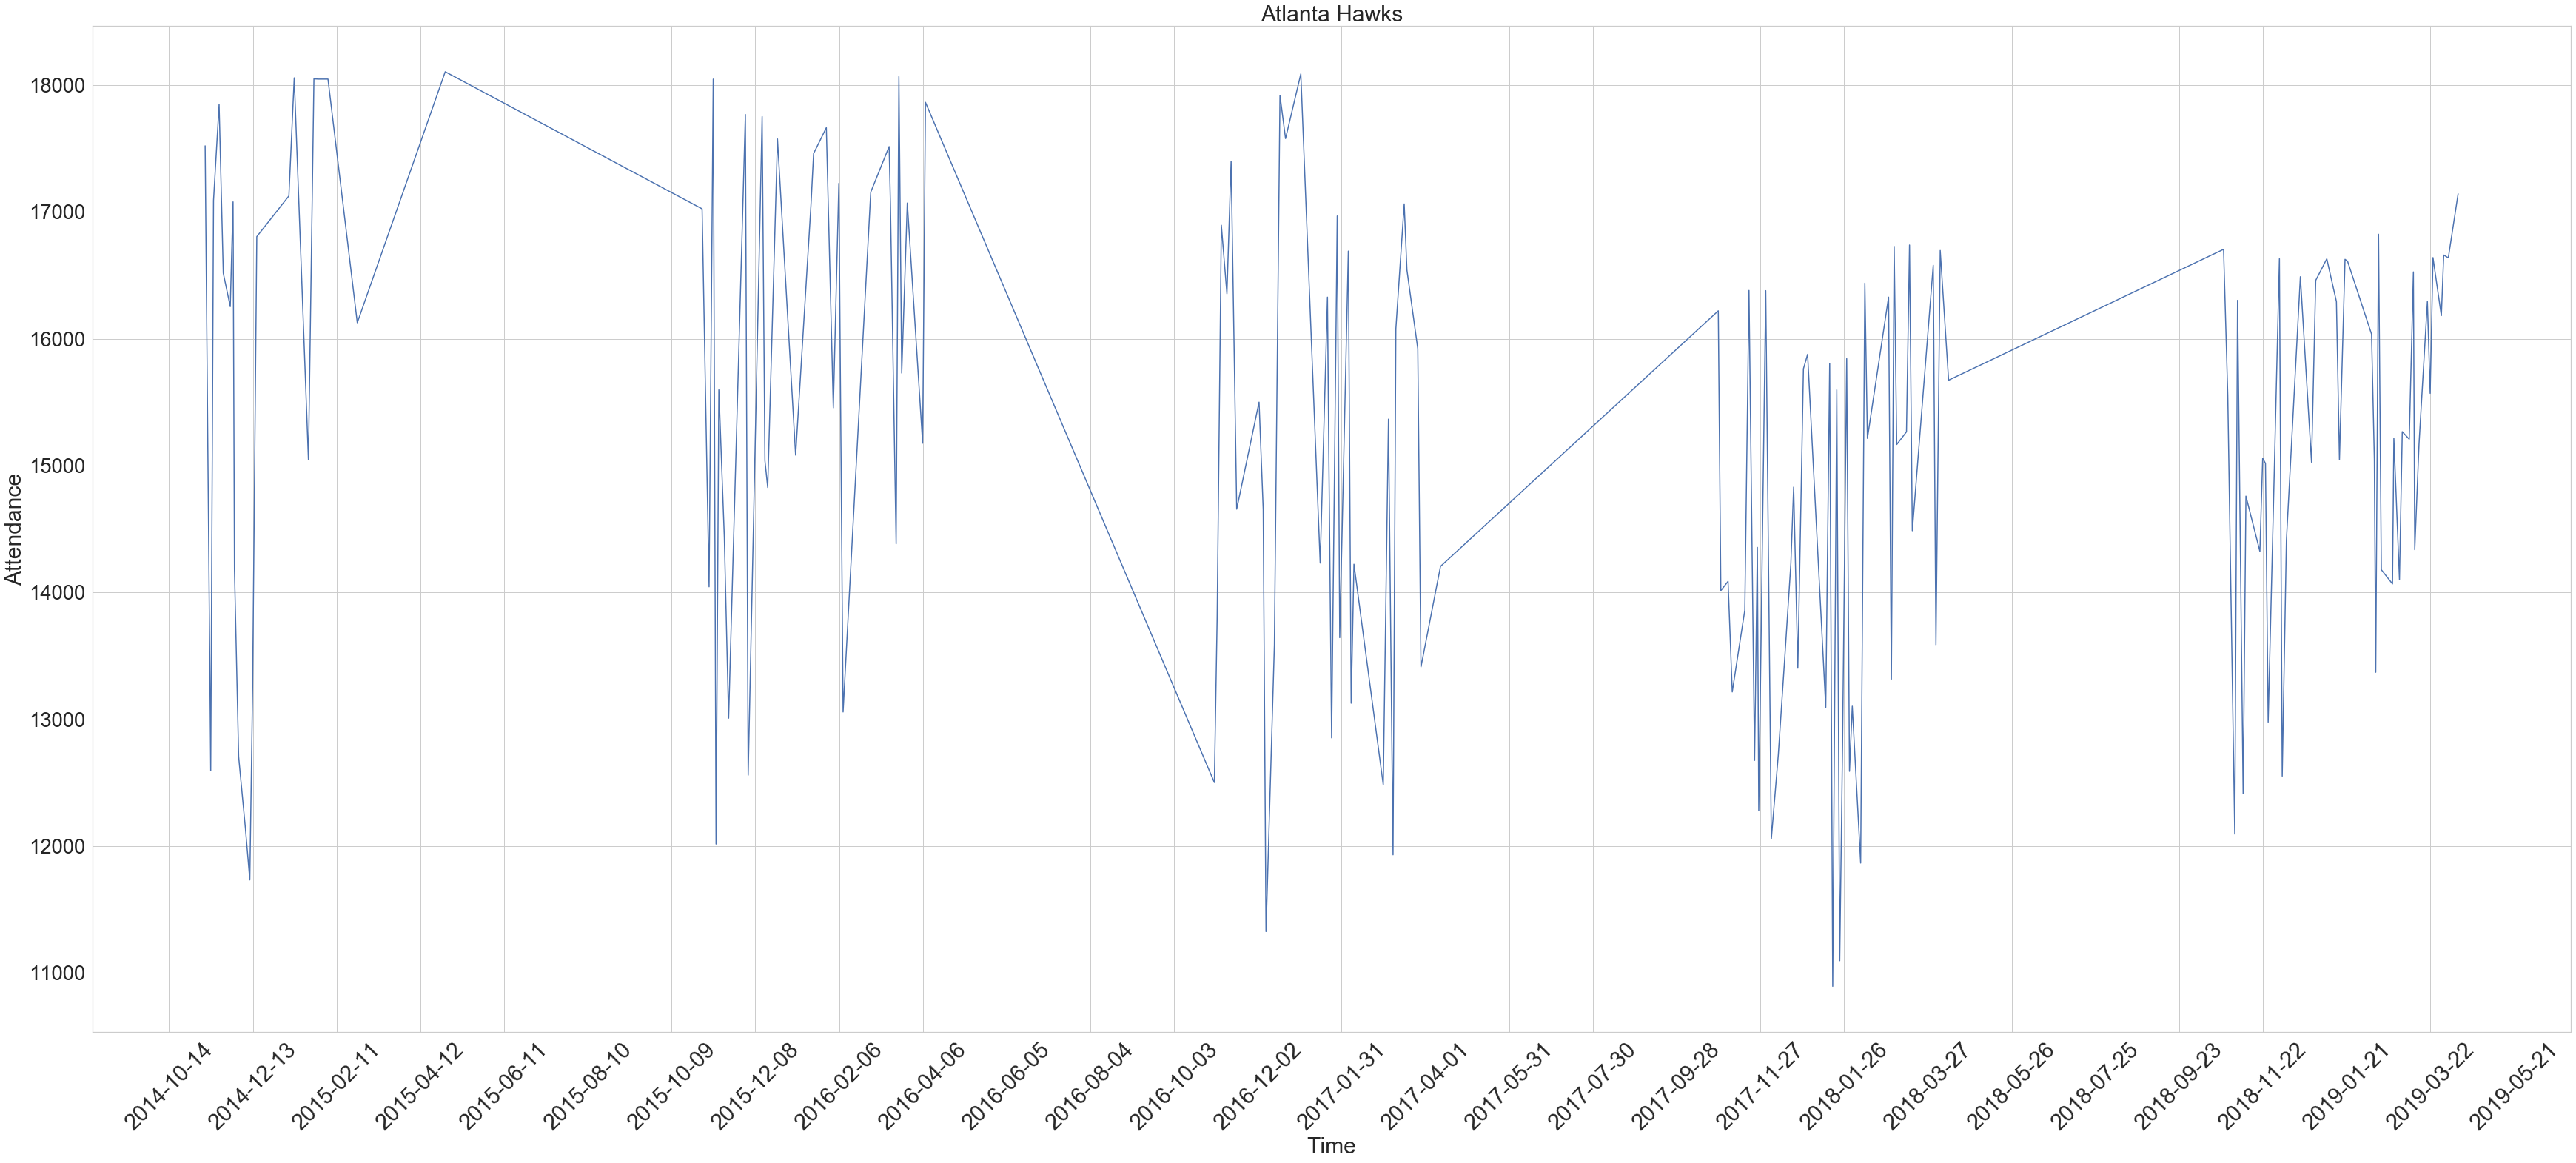

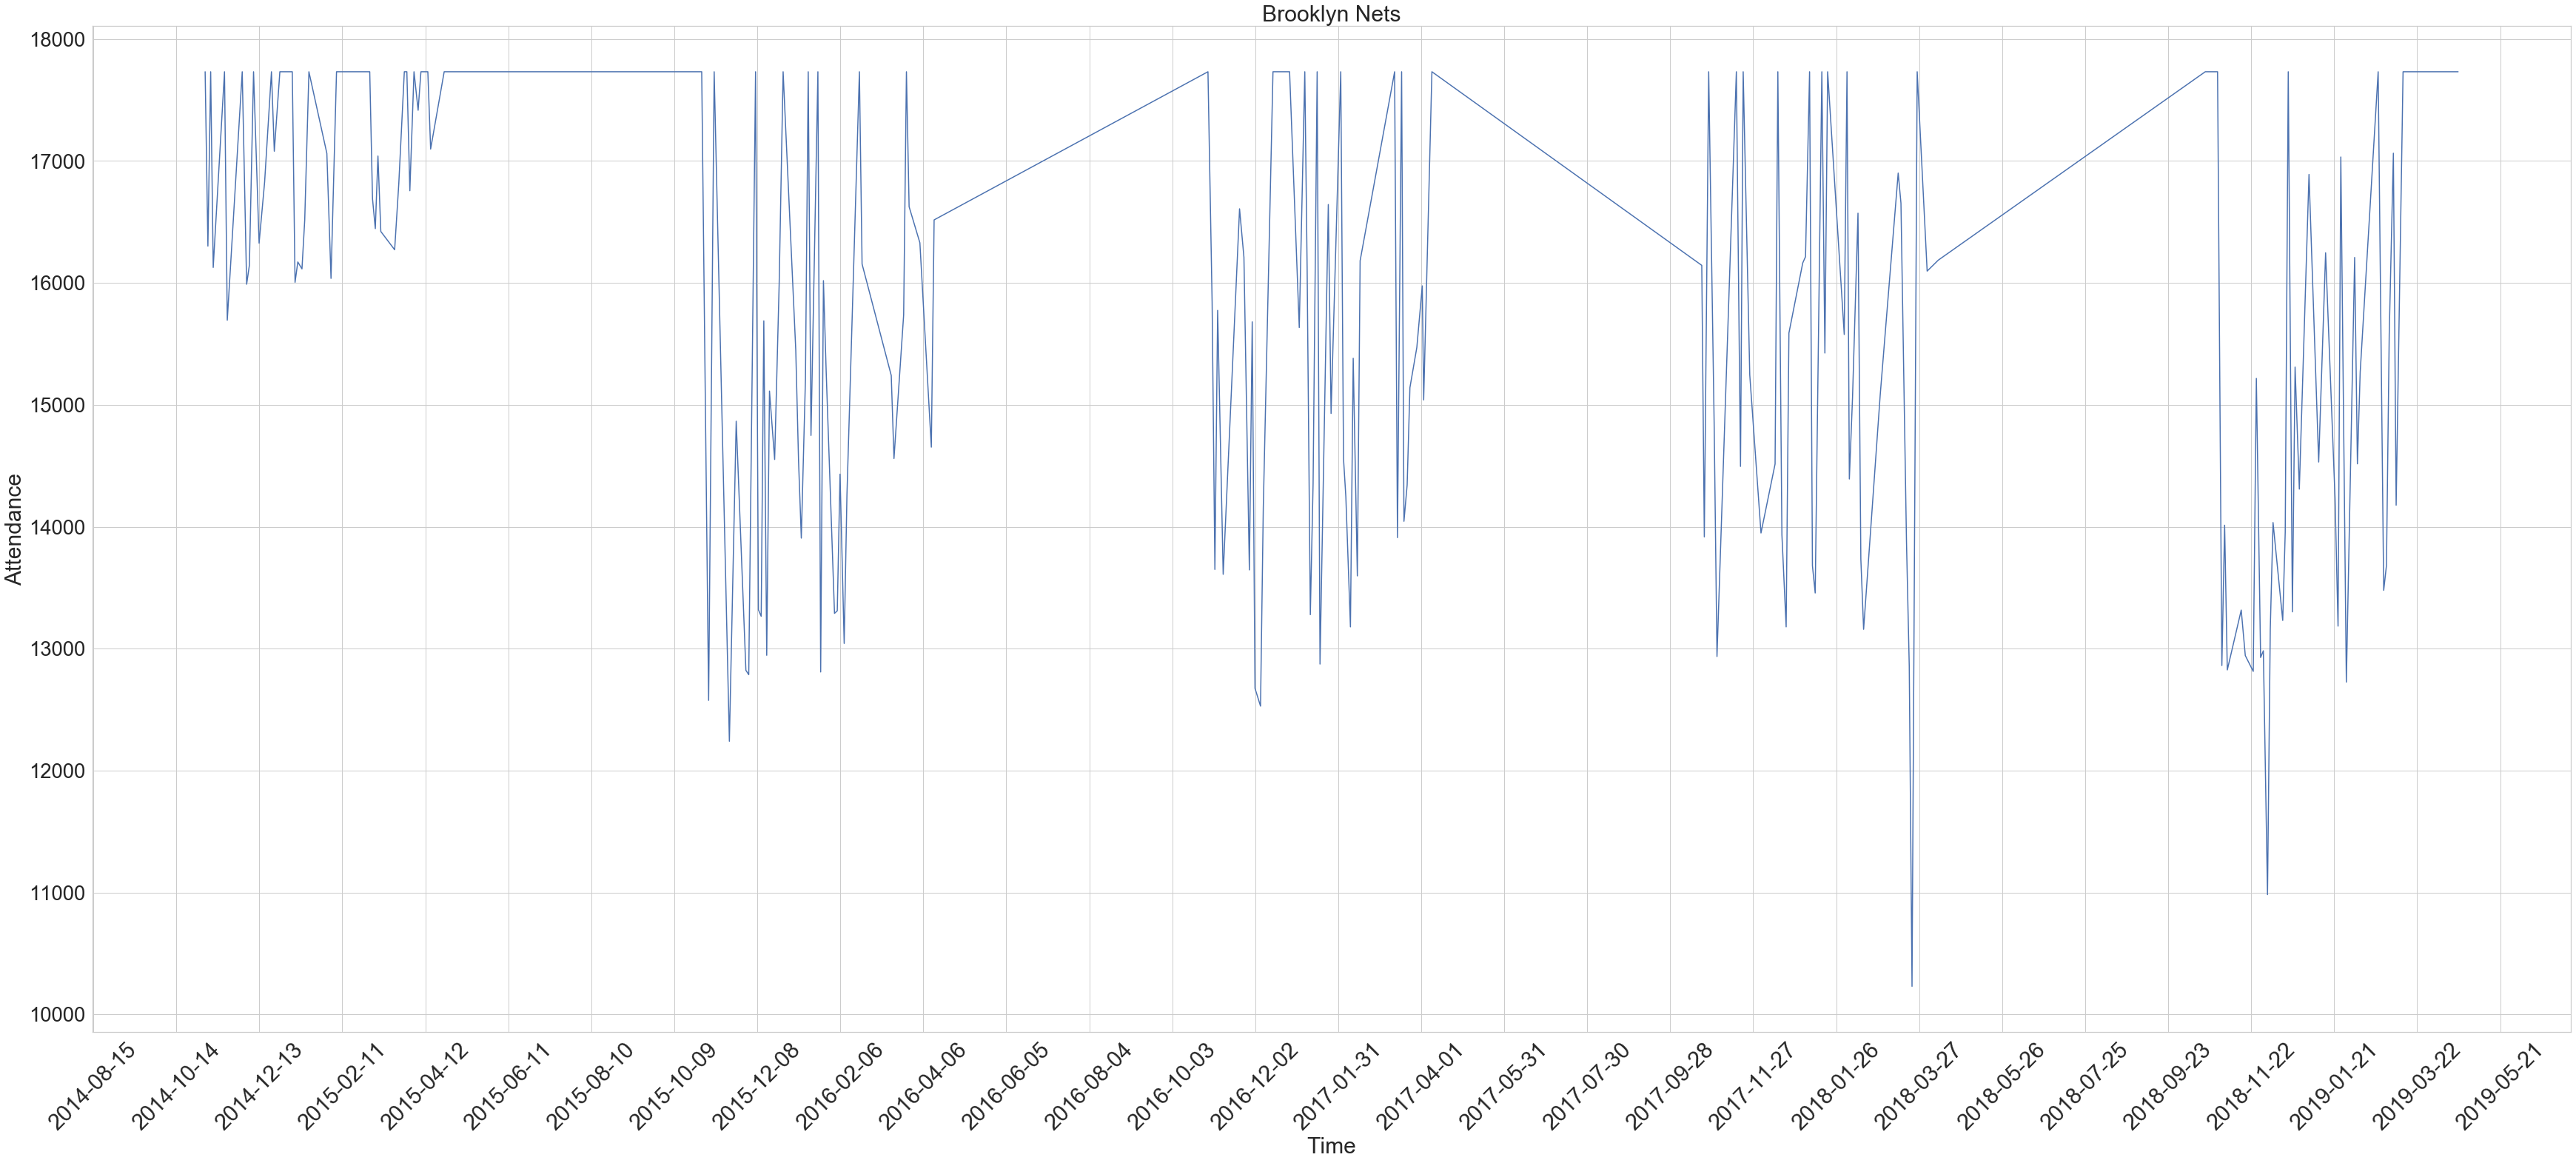

In [23]:
#Plot the time_series
teams = all_data_df['Home'].unique()
for i,team in enumerate(teams):
    filtered = all_data_df.loc[all_data_df['Home'] == team]
    fig, ax = plt.subplots(figsize=(60,25))
    ts = sns.lineplot(ax = ax, x = 'Time', y = 'Attendance', data = filtered)
    max_xticks = 35
    sns.set(font_scale = 2.5)
    sns.set_style("whitegrid")
    xloc = plt.MaxNLocator(max_xticks)
    ax.xaxis.set_major_locator(xloc)
    plt.setp(ax.get_xticklabels(), rotation=45, fontsize=30)
    plt.title(team)
    display(ts)
    

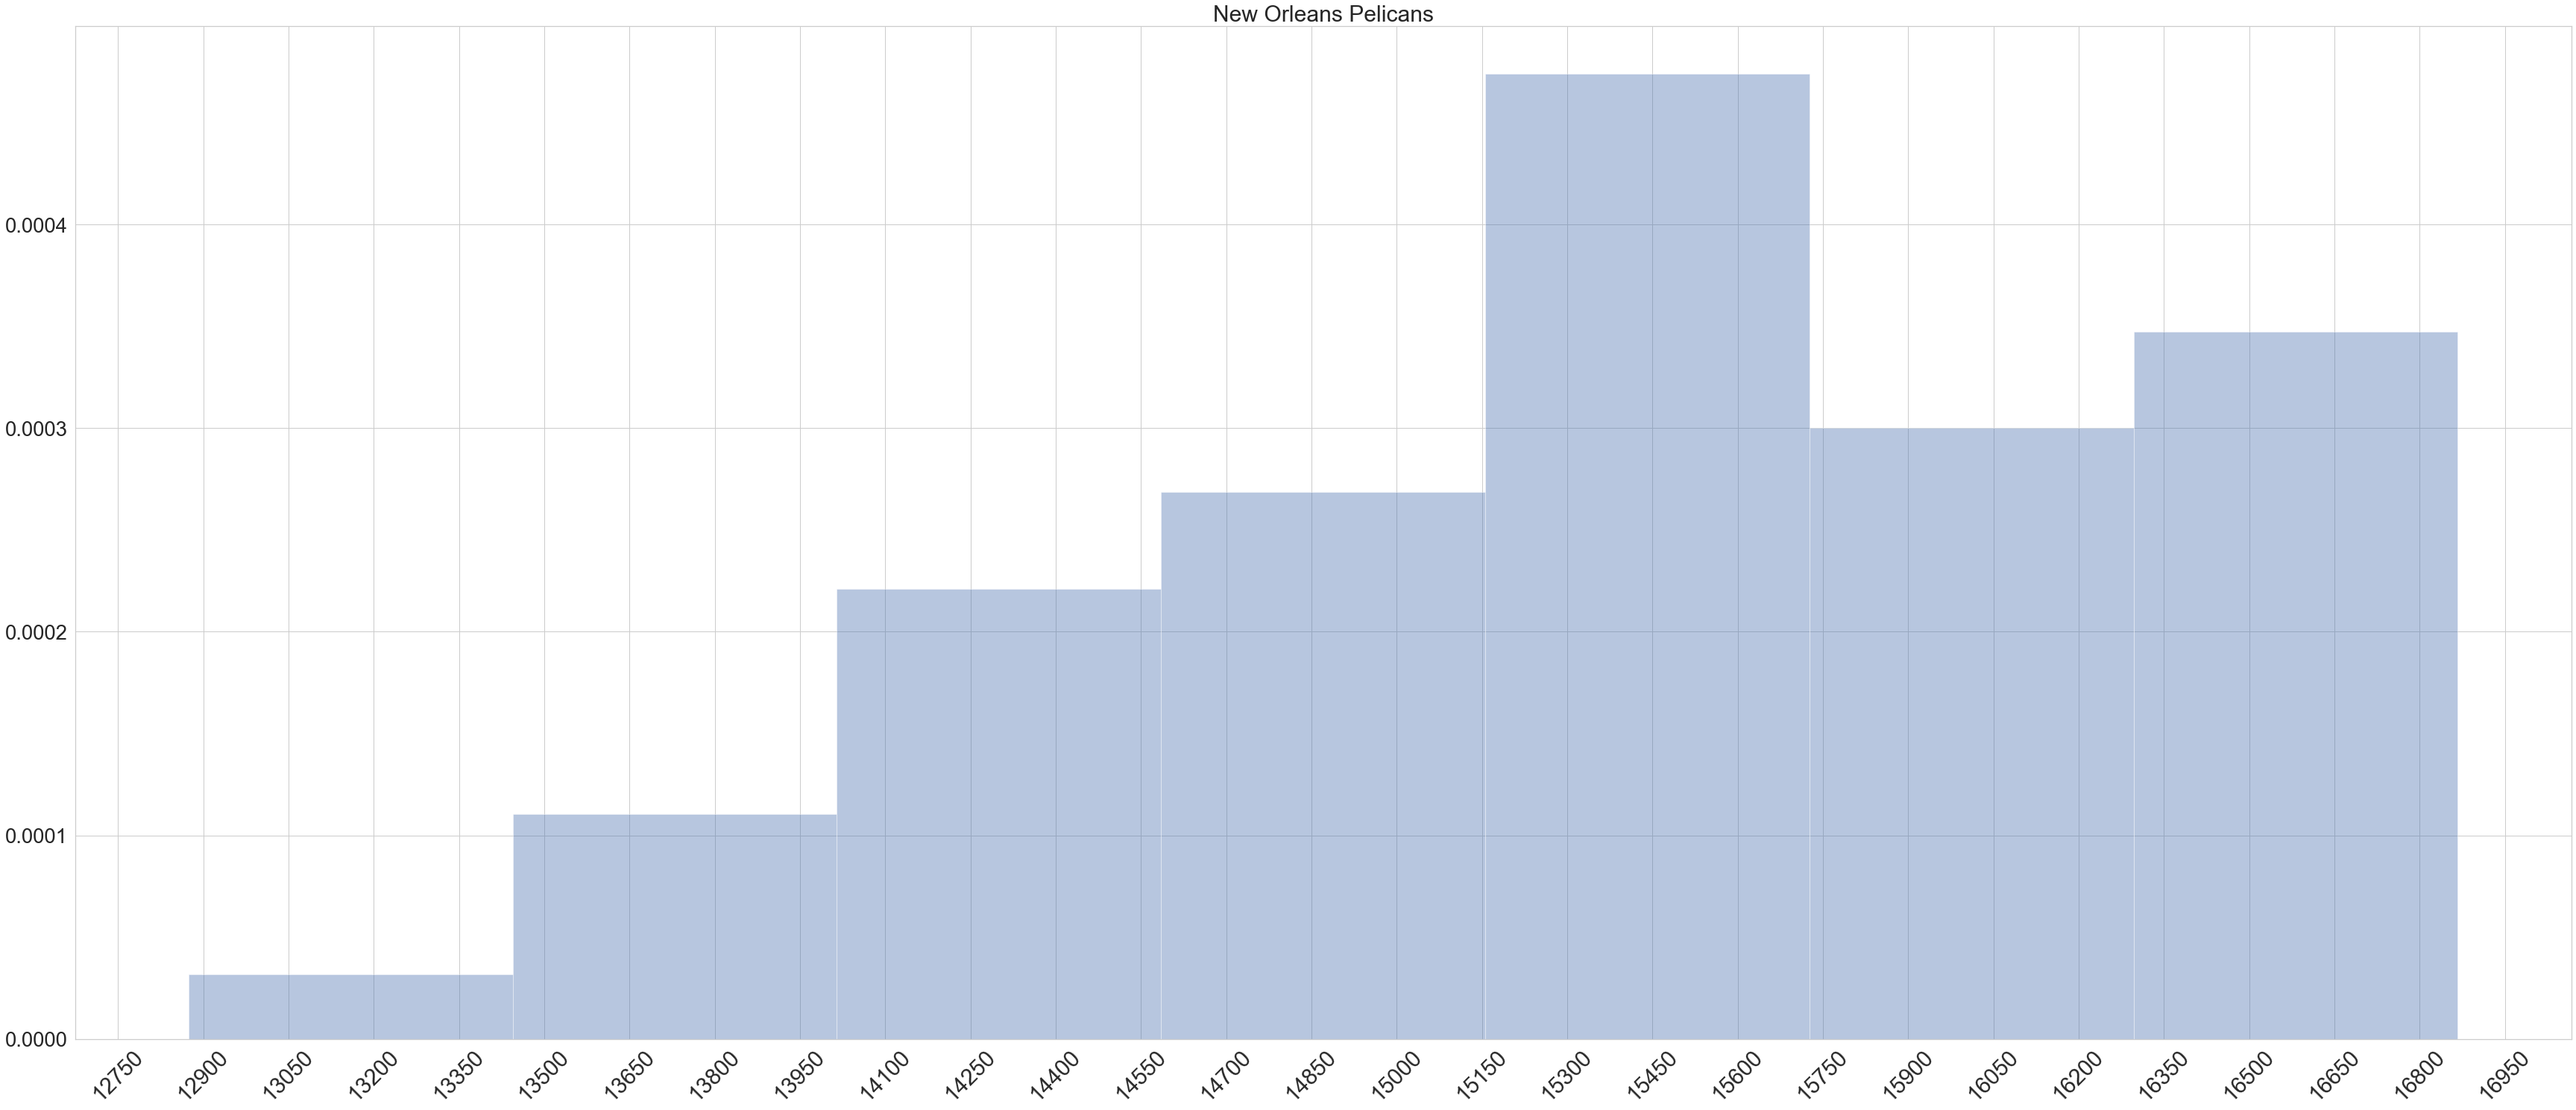

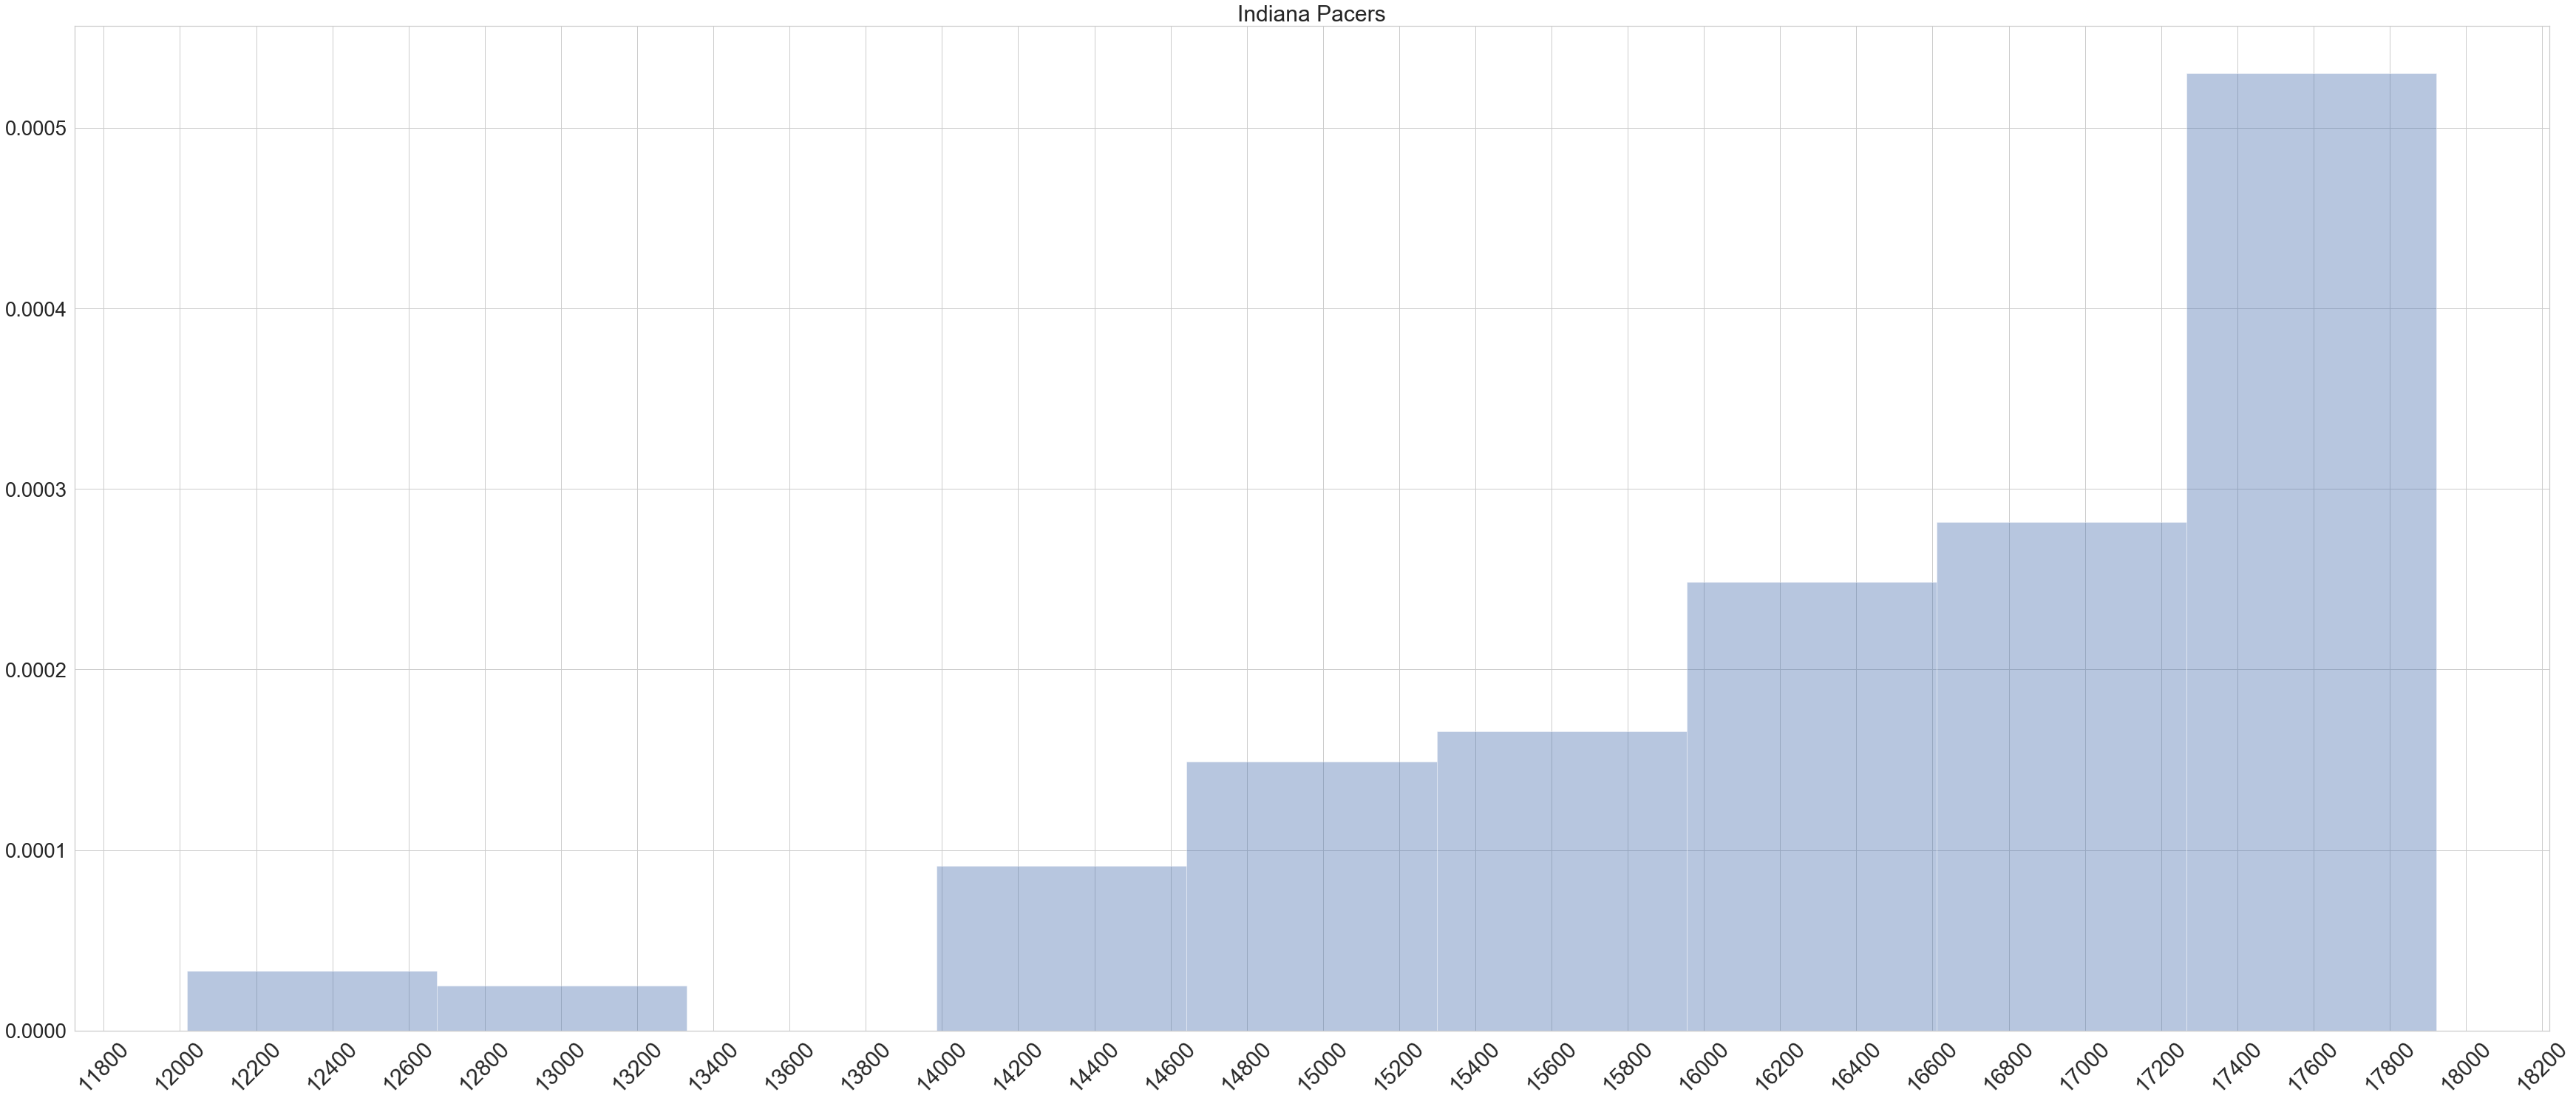

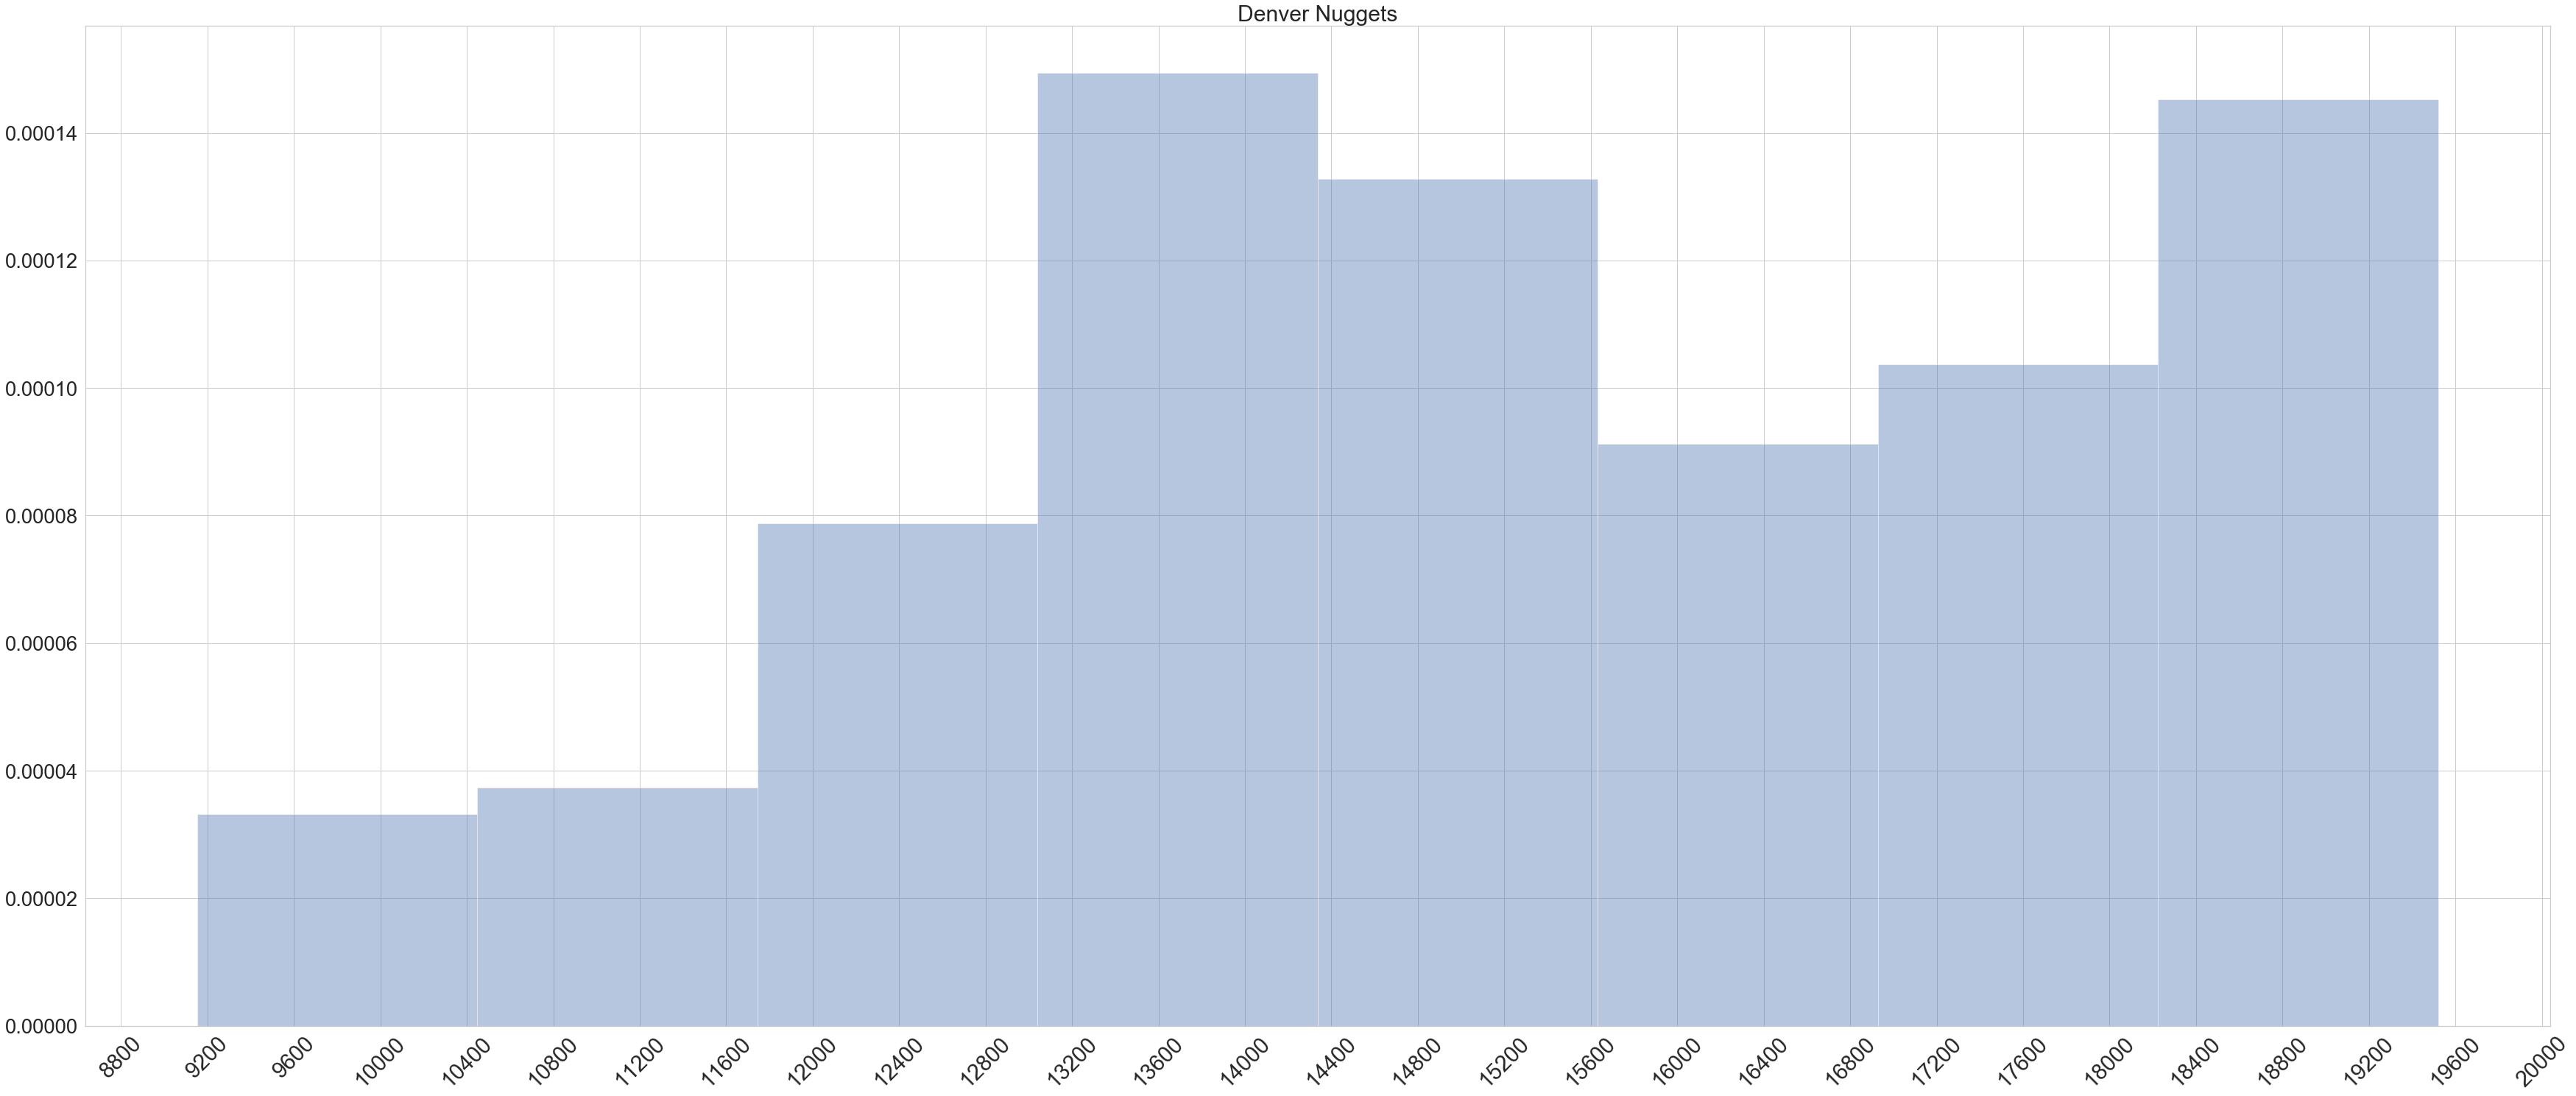

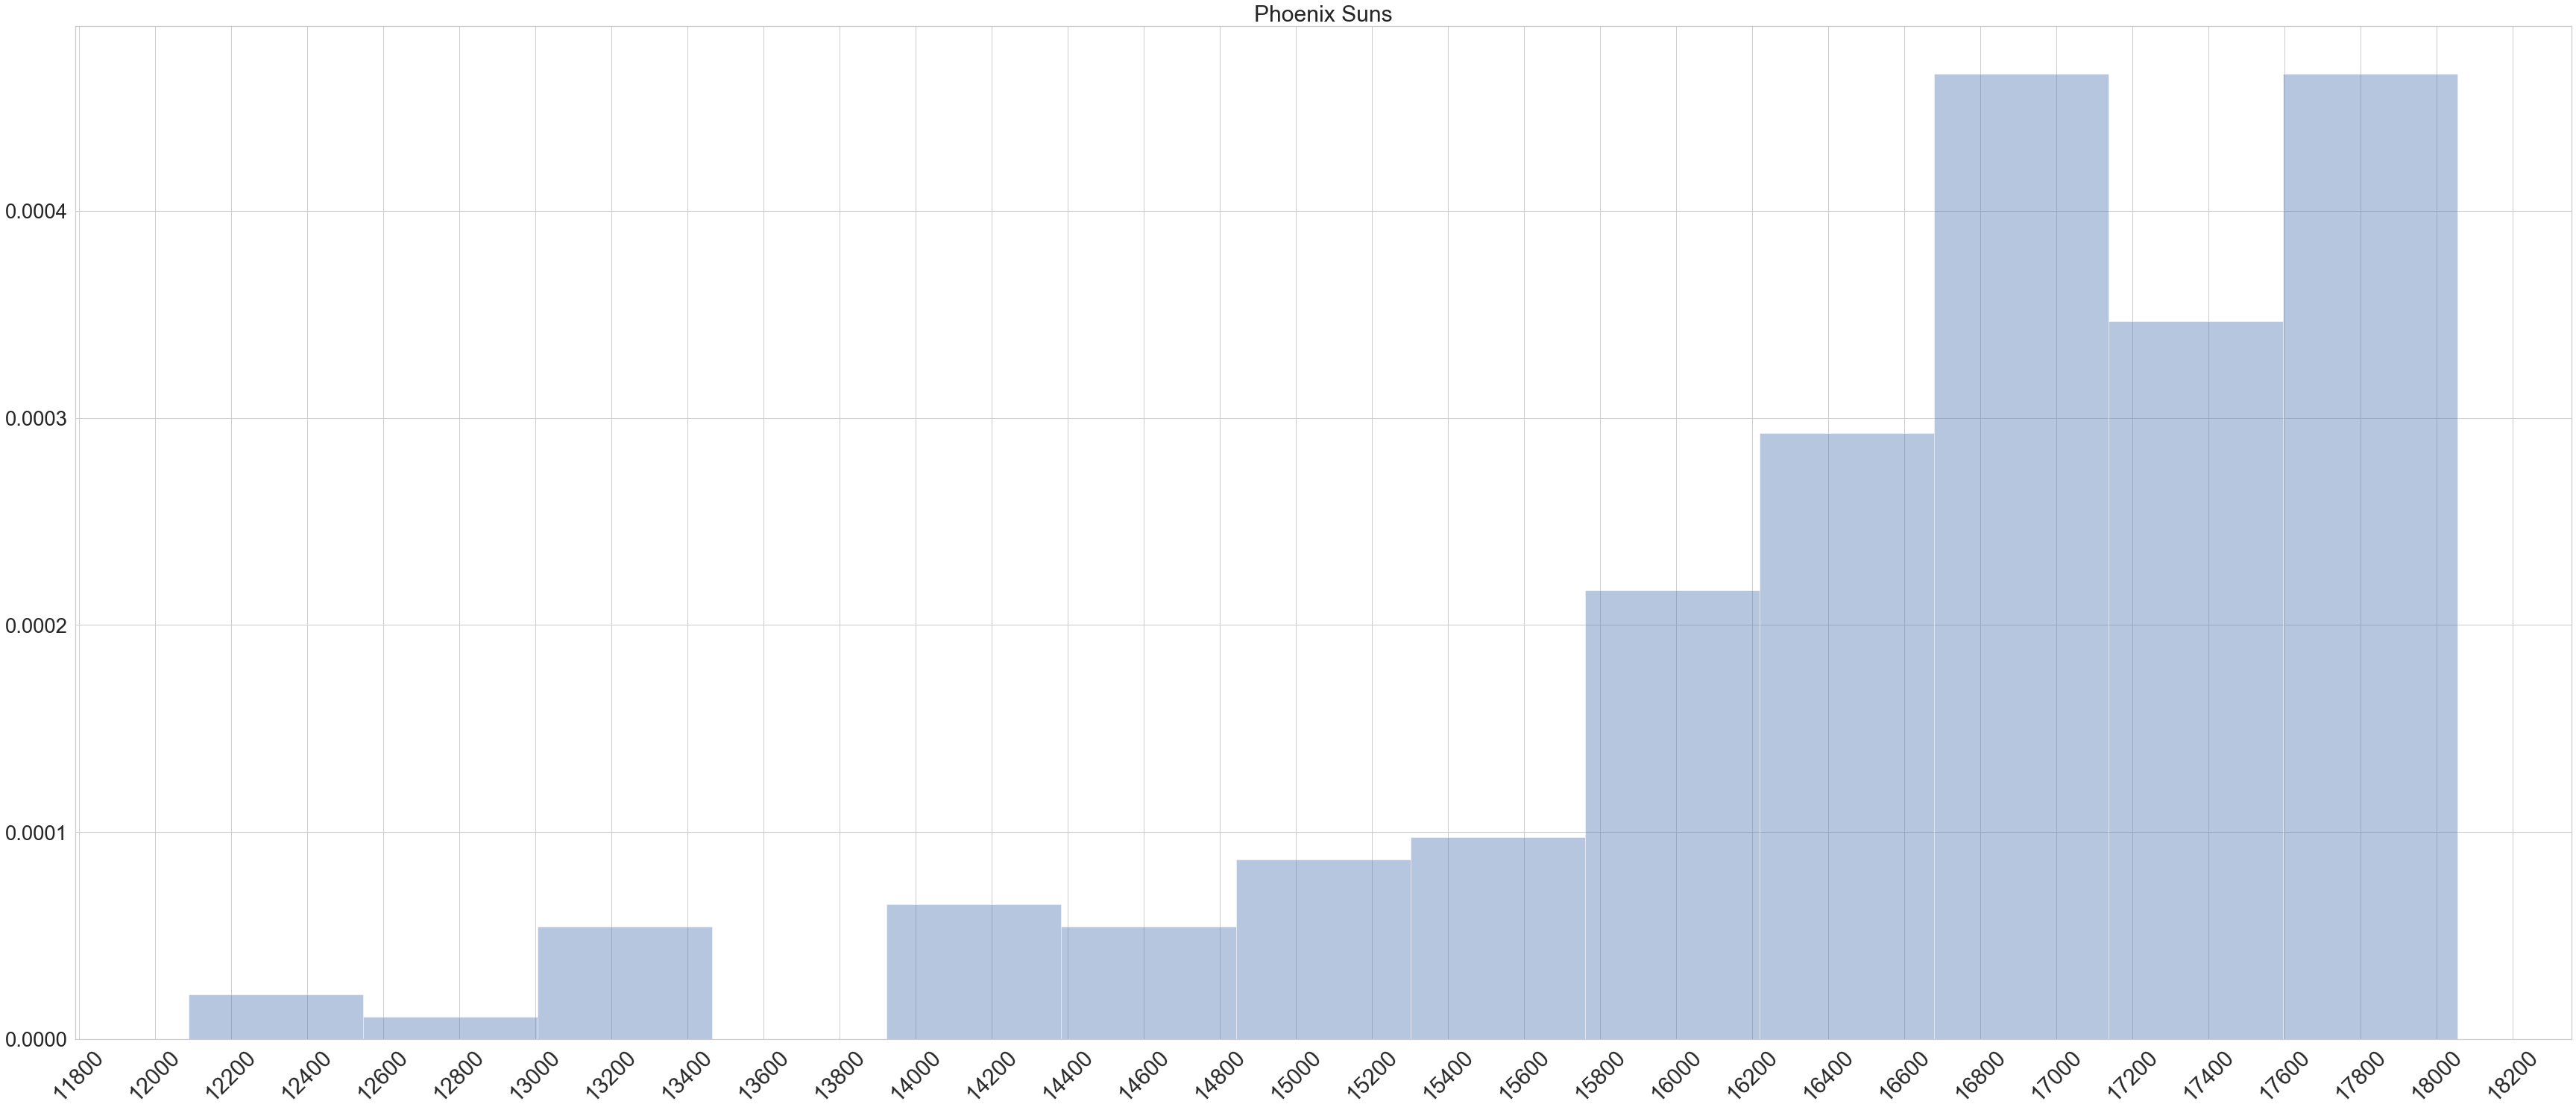

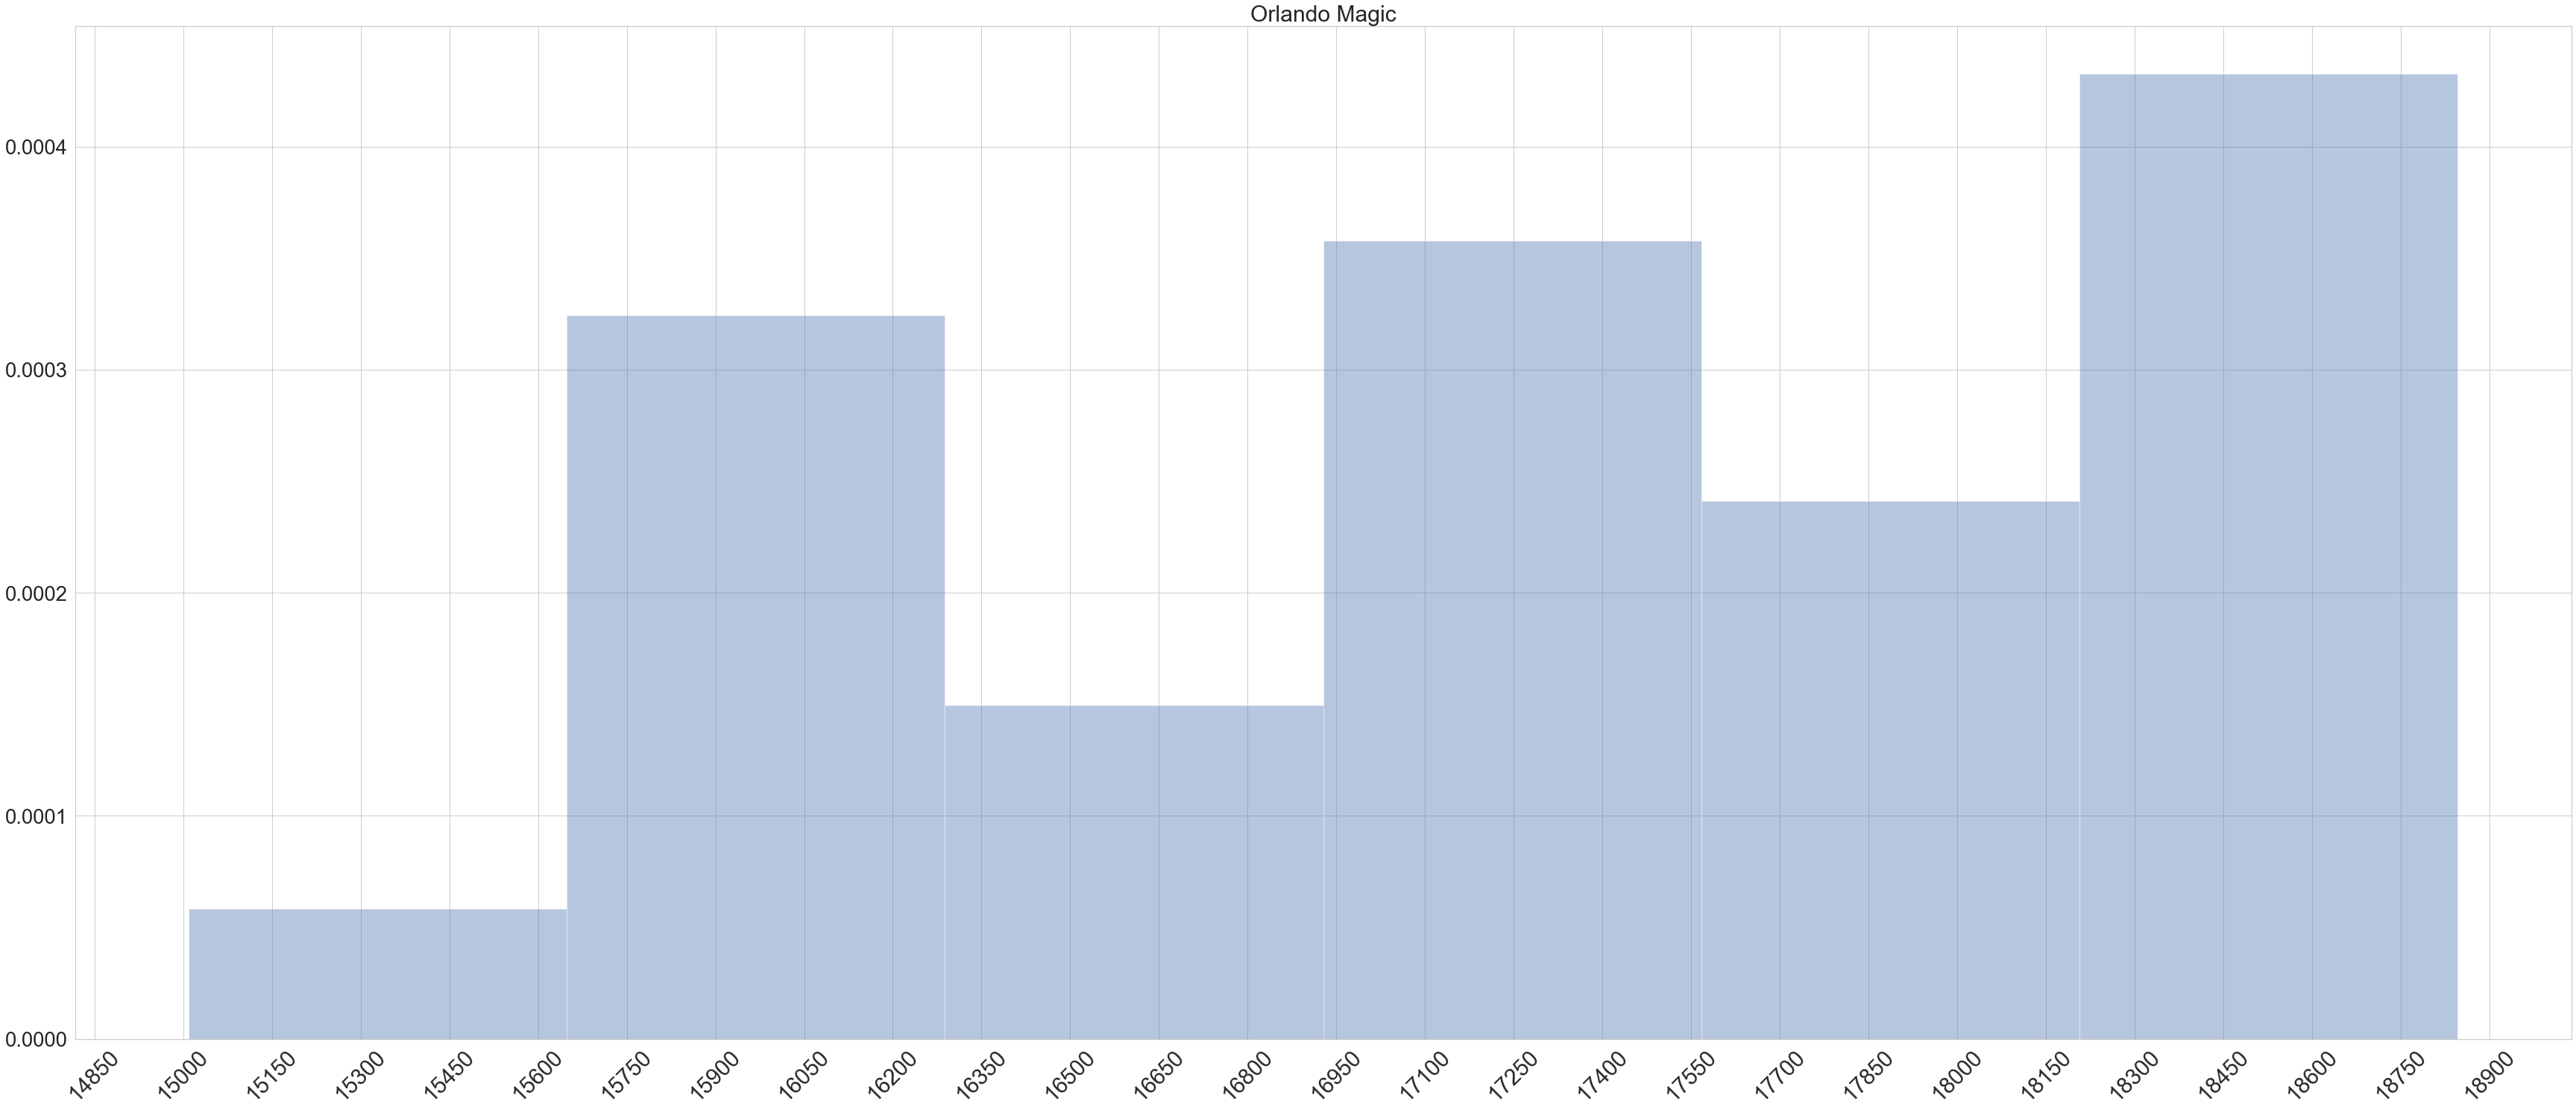

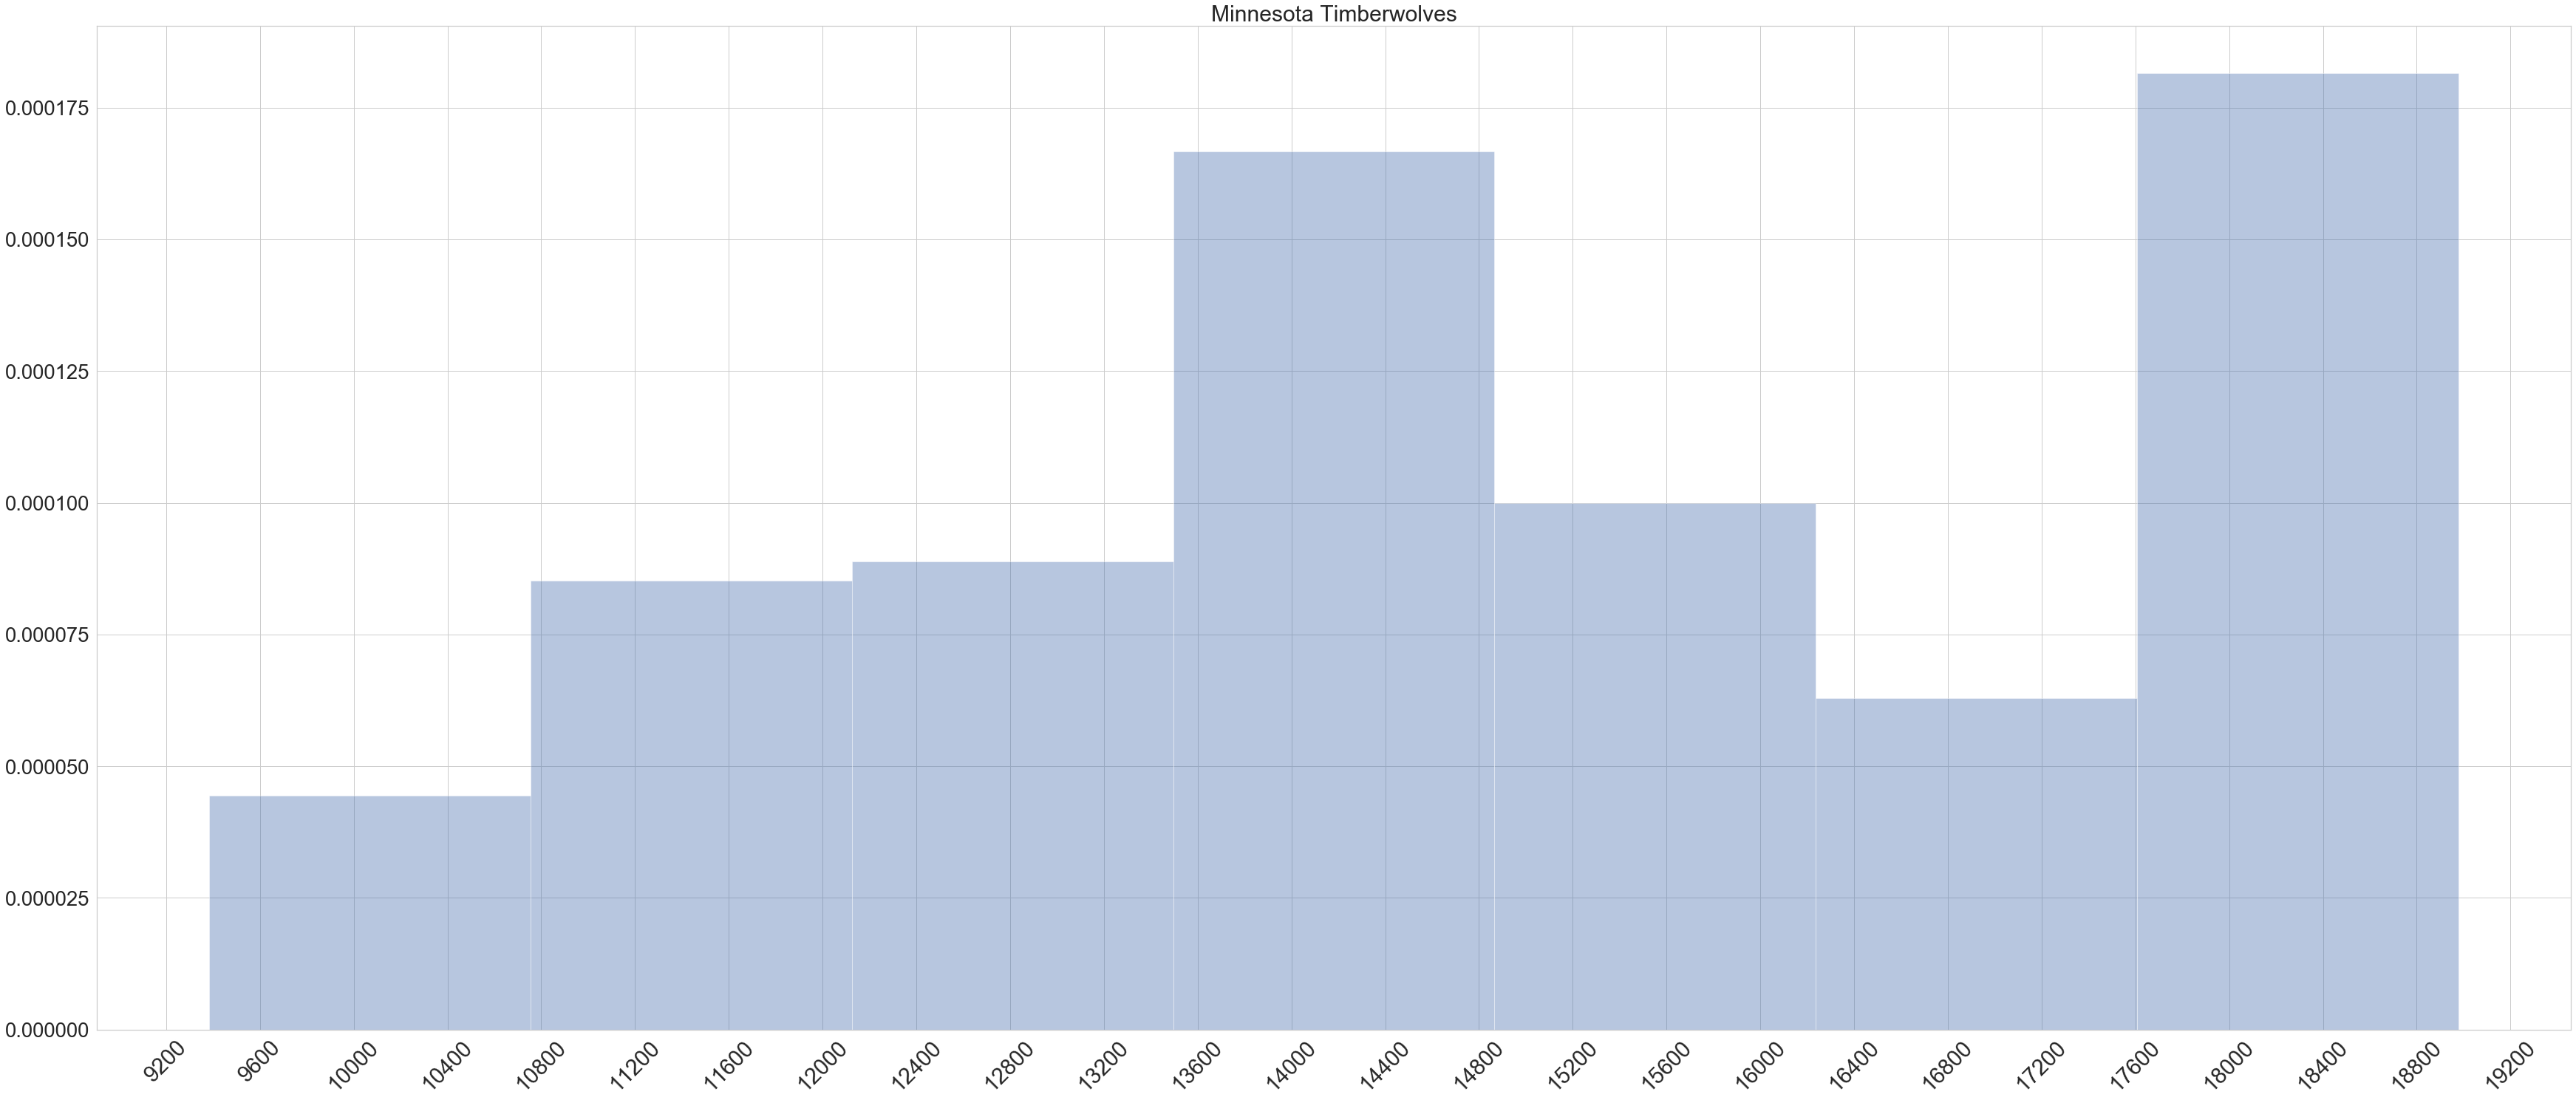

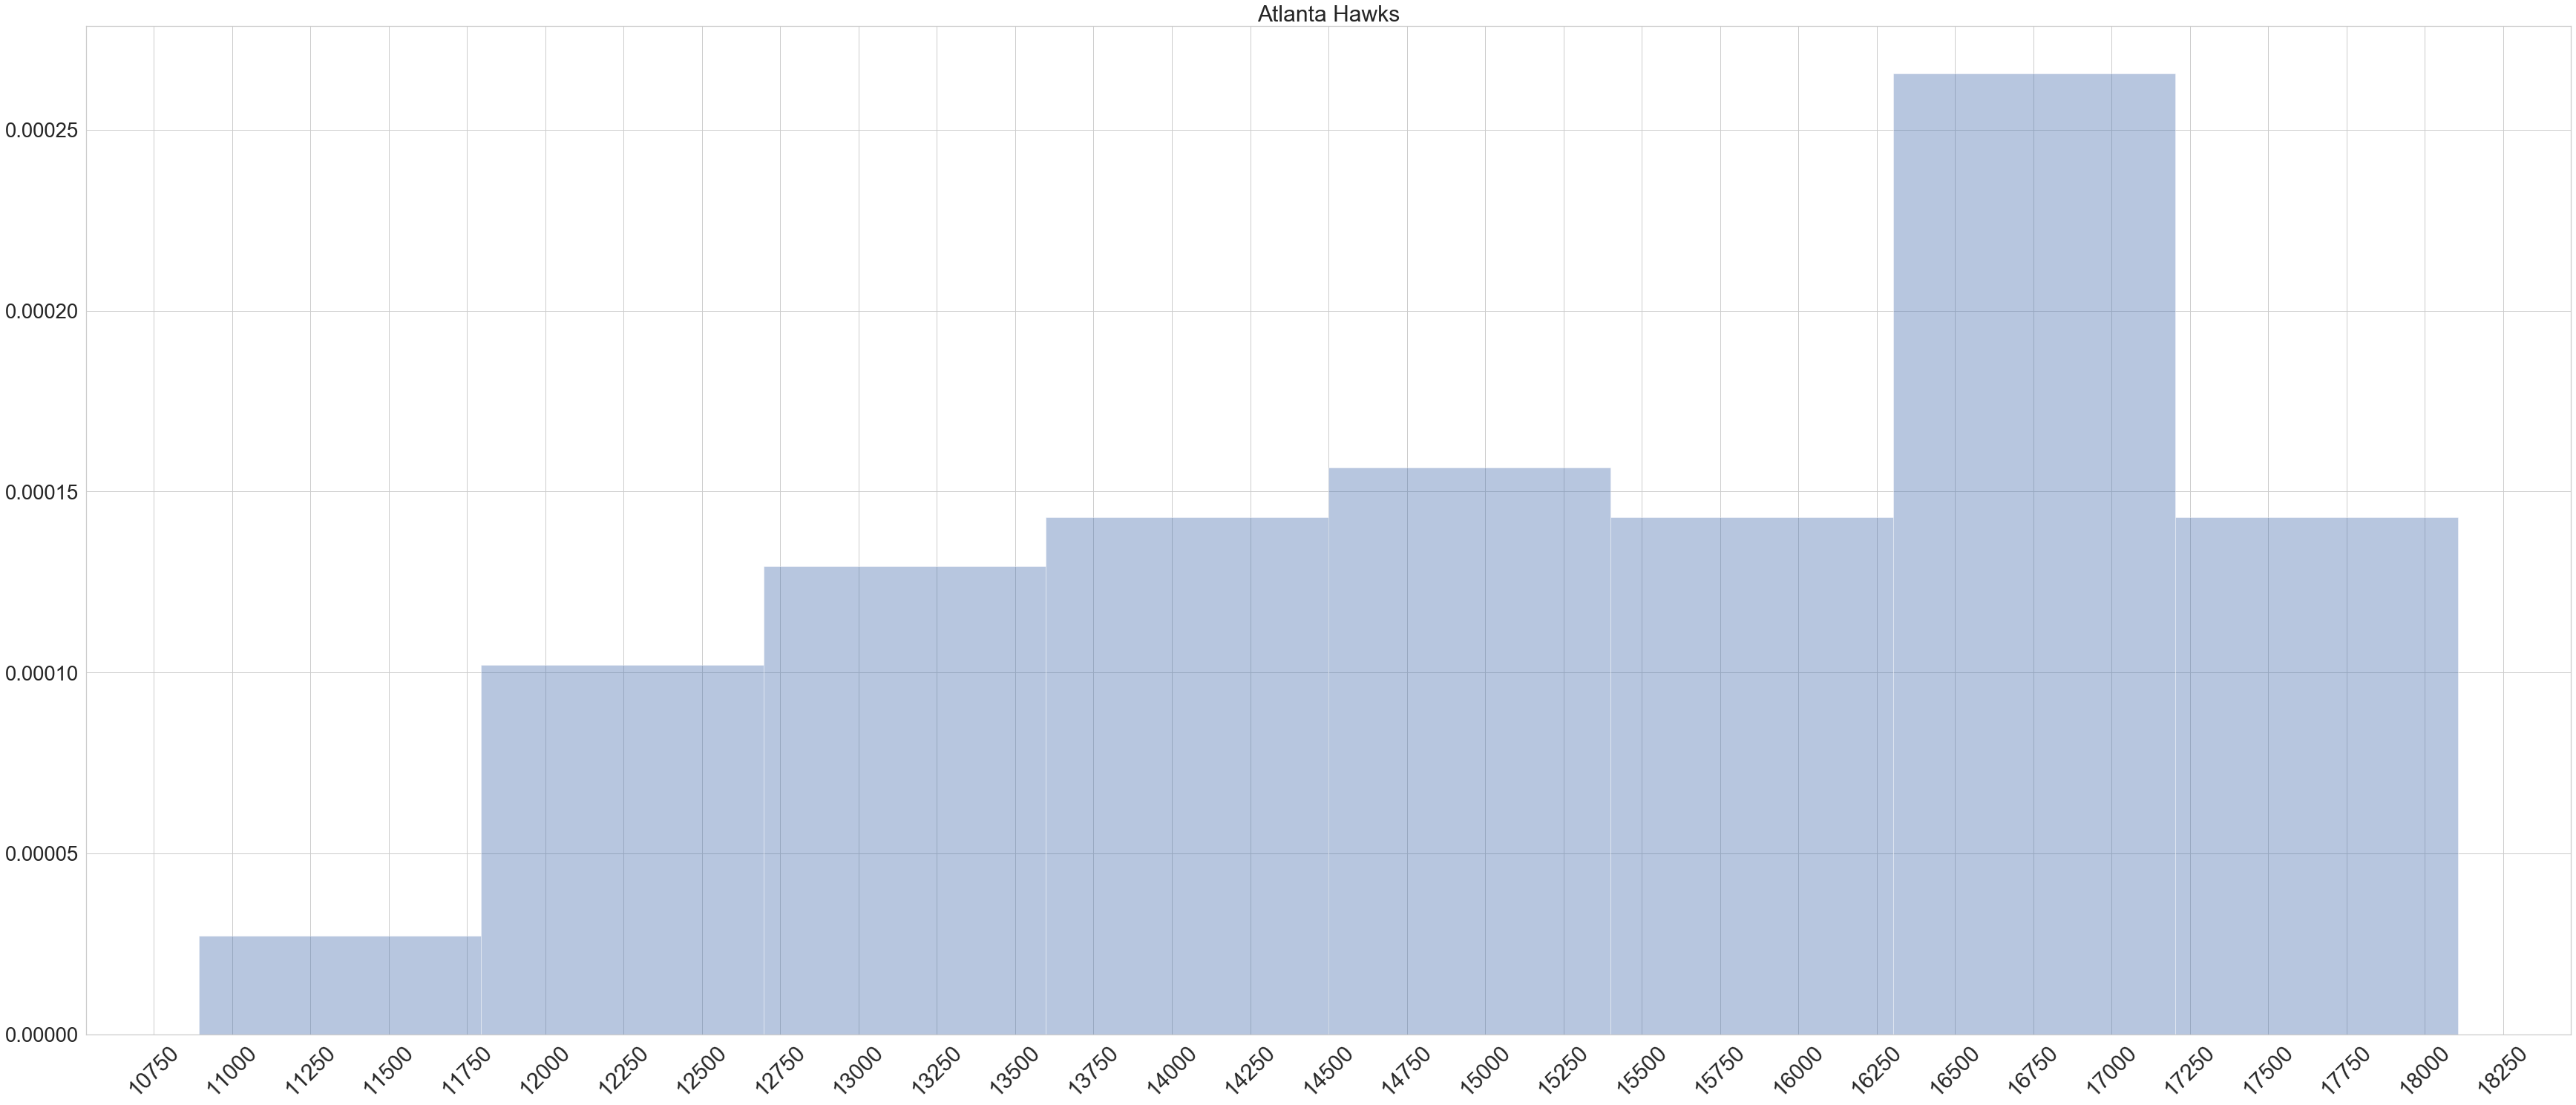

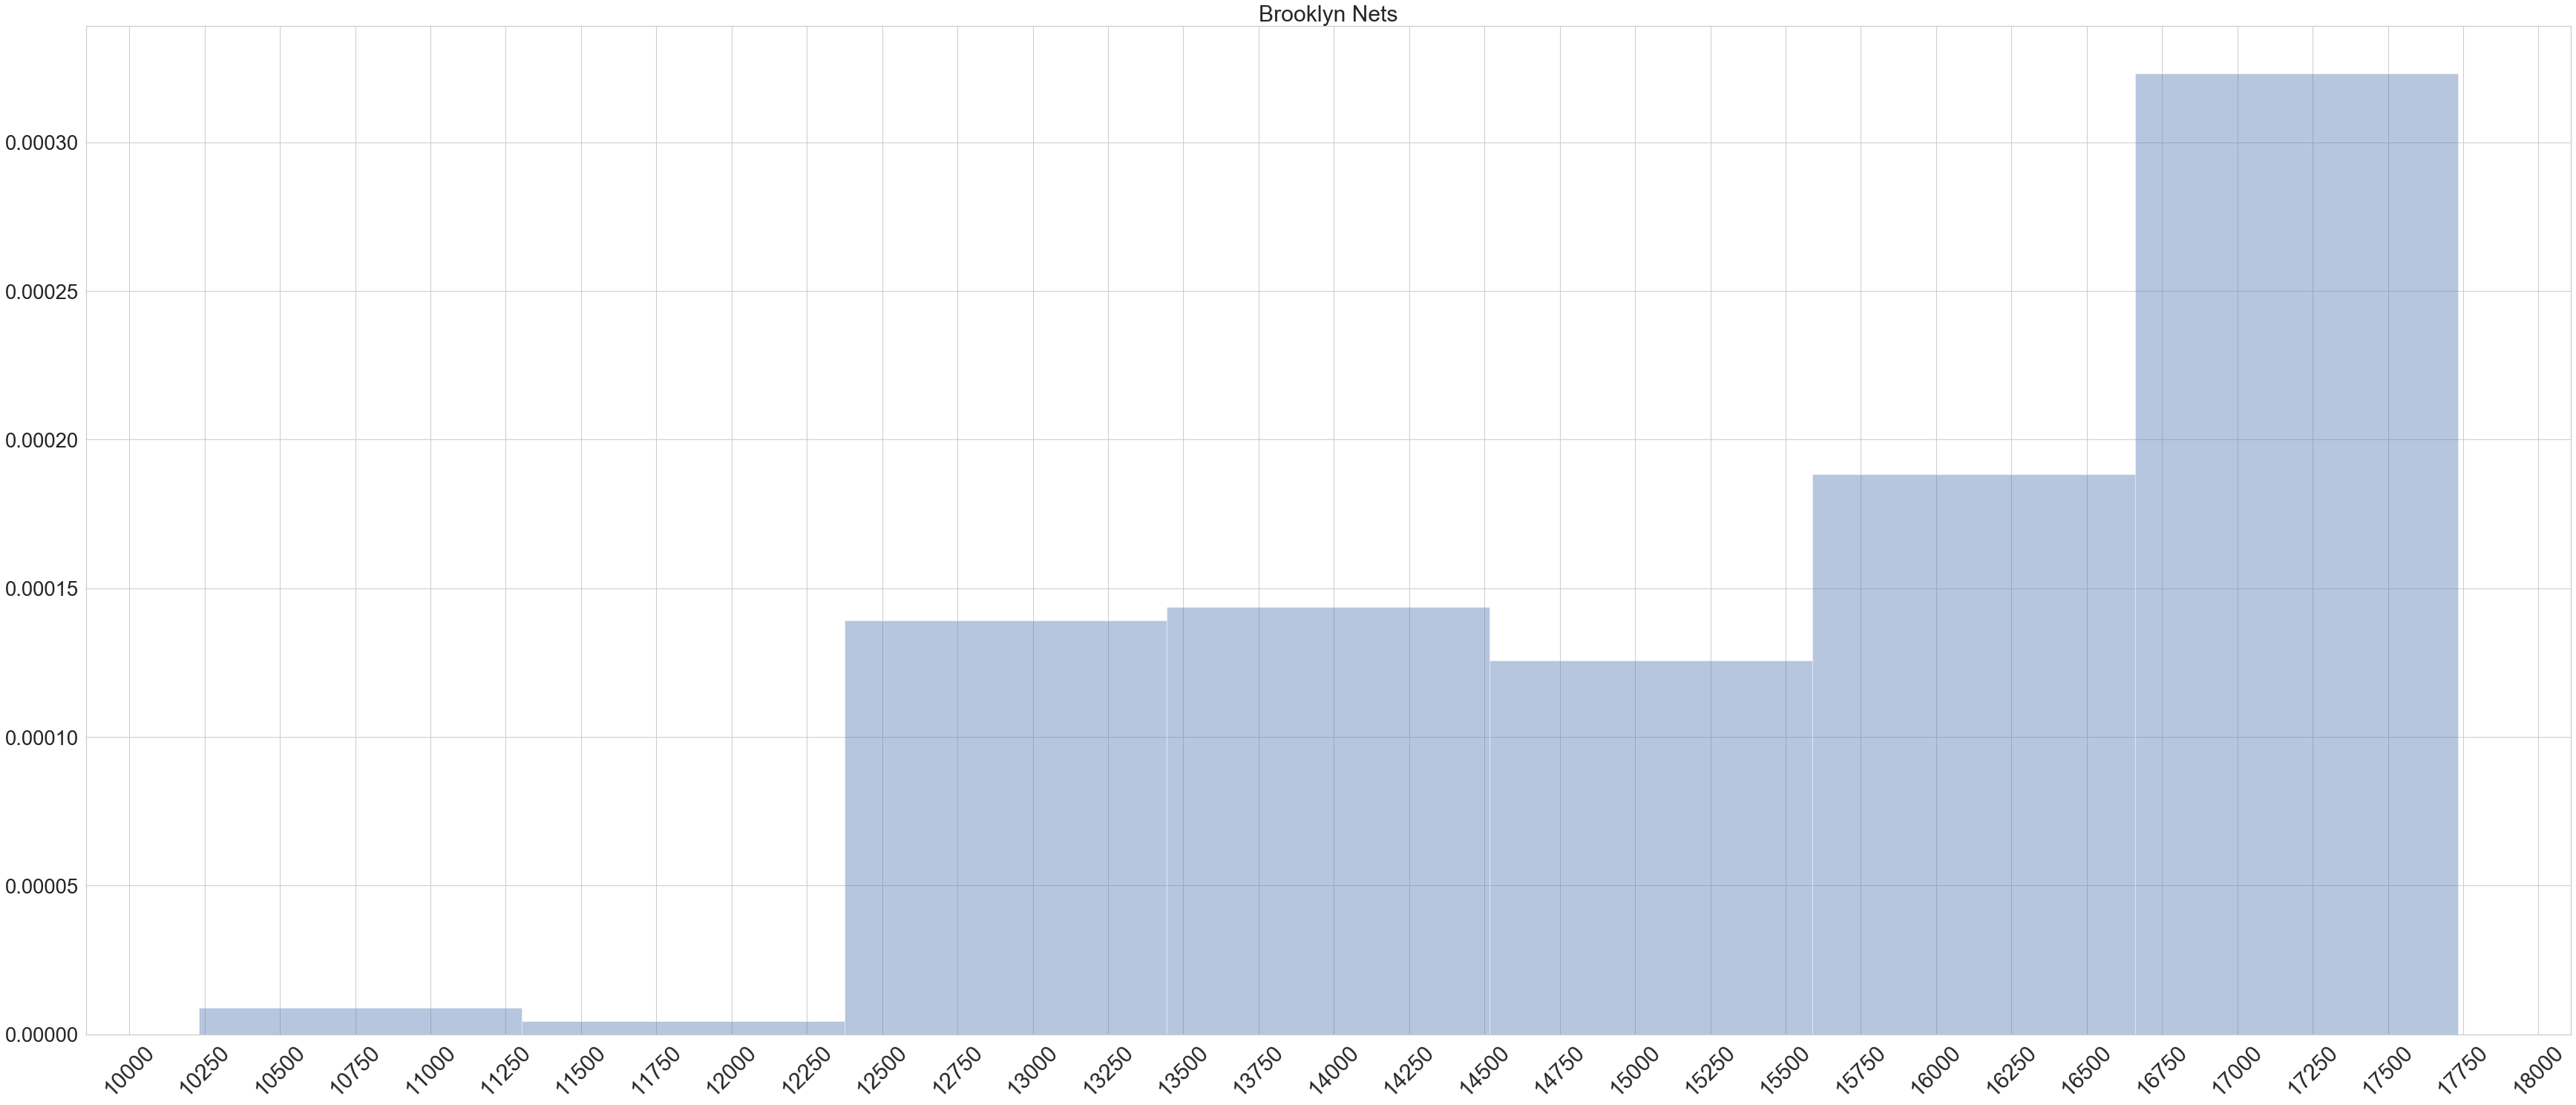

In [26]:
#plot histograms of attendance 
for i,team in enumerate(teams):
    filtered = all_data_df.loc[all_data_df['Home'] == team]
    fig, ax = plt.subplots(figsize=(60,25))
    ts = sns.distplot(filtered['Attendance'].values, ax = ax, kde = False, norm_hist = True)
    max_xticks = 35
    sns.set(font_scale = 2.5)
    sns.set_style("whitegrid")
    xloc = plt.MaxNLocator(max_xticks)
    ax.xaxis.set_major_locator(xloc)
    plt.setp(ax.get_xticklabels(), rotation=45, fontsize=30)
    plt.title(team)
    display(ts)

9